In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection # For multi-coloured lines by time
from matplotlib.colors import ListedColormap, BoundaryNorm # For multi-coloured lines by time
from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection
from matplotlib.transforms import Affine2D
import glob
import scipy.stats
from scipy.stats import *
import astropy.stats
from IPython.display import display, HTML # For displaying pandas tables
import re

# Data paths
path_data        = '../Ant_Cooling_Data/'
path_output_csv  = '../Ant_Cooling_Data/Converted_to_CSV/'

# Camera recordings frame rate
fps = 25 # in frames per sec

# Plot styling
column_single = 89.0 / 25.4
column_double = 183.0 / 25.4
column_full = 247.0 / 25.4
column_80mm = 80 / 25.4
column_174mm = 174 / 25.4
column_210mm = 8.2

# Colors
line_props_full_traj     = dict(color='#444444', alpha=1.0)
point_props_nest         = dict(color='darkorange', alpha=1.0)
line_props_platform_traj = dict(color='#444444', alpha=1.0)
arrow_props_mean_traj    = dict(color='#444444', linewidth=2, alpha=1.0)
arrow_props_mean_all     = dict(color='darkorange', linewidth=2, alpha=1.0)
arrow_props_mean_all     = dict(color='darkorange', alpha=0.7)
time_props_errorbar      = dict(color='#444444', alpha=1.0)
stats_props_errorbar_1   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_2   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_3   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_4   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_5   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_6   = dict(color='#444444', alpha=1.0)
stats_props_errorbar_7   = dict(color='#444444', alpha=1.0)

plot_style = {
    "font.family": "Arial",     # specify font family here
    "font.size"  : 10,
    "axes.spines.top"    : False, 
    "axes.spines.right"  : False, 
    "xtick.direction"     : "out",
    "ytick.direction"     : "out",
    "xtick.color"         : "black",
    "ytick.color"         : "black"
}
plt.rcParams.update(plot_style) # Update the style


# Some useful functions
def cart2pol(x, y):
    """ 
    Convert from Cartesian to polar coordinates.
    Based on https://ocefpaf.github.io/python4oceanographers/blog/2015/02/09/compass/

    Example
    -------
    >>> theta, radius = pol2cart(x, y)
    """
    
    radius = np.hypot(x, y)
    theta = np.arctan2(y, x)
    theta[theta<0] += 2*np.pi
    return theta, radius


def compass(u, v, ax, arrowprops=None):
    """
    compass draws a graph that displays the vectors with
    components `u` and `v` as arrows from the origin.

    Examples
    --------
    >>> import numpy as np
    >>> u = [+0, +0.5, -0.50, -0.90]
    >>> v = [+1, +0.5, -0.45, +0.85]
    >>> compass(u, v)
    """

    angles, radii = cart2pol(u, v)

    kw = dict(arrowstyle="->", color='k')
    if arrowprops:
        kw.update(arrowprops)
    [ax.annotate("", xy=(angle, radius), xytext=(0, 0), arrowprops=kw) for angle, radius in zip(angles, radii)]


def compass_pol(angles, radii, ax, arrowprops=None):
    """
    compass_pol draws a graph that displays the vectors with
    components `angles` and `radii` as arrows from the origin.

    Examples
    --------
    >>> import numpy as np
    >>> compass(angles, radii)
    """

    kw = dict(arrowstyle="->", color='k')
    if arrowprops:
        kw.update(arrowprops)
    [ax.annotate("", xy=(angle, radius), xytext=(0, 0), arrowprops=kw) for angle, radius in zip(angles, radii)]
    
    ax.set_ylim(0, np.max(radii))

    
def compass_sector_pol(angle_from, angle_to, radius, ax, sectorprops=None):
    """
    Plots a solid sector on a polar graph. The sector start and end angles 
    angle_from and angle_to are in radians. The radius of the sector is radius. 

    Examples
    --------
    >>> import numpy as np
    >>> compass(np.pi-np.pi/36, np.pi+np.pi/36, 1.0)
    """

    kw = dict()
    if sectorprops:
        color = sectorprops.get('color', 'black')
        alpha = sectorprops.get('alpha', 1.0)
    else:
        color = 'black'
        alpha = 1.0

    ax.add_artist(Wedge((.5,.5), radius, np.degrees(angle_from), np.degrees(angle_to), transform=ax.transAxes, color=color, alpha=alpha))
    ax.set_ylim(0, np.max(radius))


def circ_r_alpha(alpha, w=None):
    """ Based on matlab circular statistics toolbox 
        https://uk.mathworks.com/matlabcentral/fileexchange/10676-circular-statistics-toolbox-directional-statistics 
    """
    if w is None:
        w = np.ones(alpha.shape)
    
    x_total = np.sum(np.cos(alpha) * w)
    y_total = np.sum(np.sin(alpha) * w)
    r = np.sqrt(x_total**2 + y_total**2)
    return r / np.sum(w)


def circ_r_xy(x, y, w=None):
    """ Based on matlab circular statistics toolbox 
        https://uk.mathworks.com/matlabcentral/fileexchange/10676-circular-statistics-toolbox-directional-statistics 
    """
    if w is None:
        w = np.ones(x.shape)
    
    x_total = np.sum(x * w)
    y_total = np.sum(y * w)
    r = np.sqrt(x_total**2 + y_total**2)
    return r / np.sum(w)


def reject_outliers(data):
    """ Rejects outliers from a dataset """
    
    # calculate interquartile range
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25

    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in data if x < lower or x > upper]

    # remove outliers
    without_outliers = [x for x in data if x >= lower and x <= upper]
    
    return (without_outliers, outliers)


def circ_stat_tests(data, print_data=True):
    """ Calculates statistical significance of circular data between multiple conditions.
        data: a dictionary with each entry being the measurements in radians for each condition as 1D arrays. 
        The keys of the dict are the names of the conditions. 
        Returns the stats in a dictionary with structure stat_test_dict[<TEST>][<COND_ROW>][<COND_COLUMN>]
    """

    # The conditions
    conditions = list(data.keys())

    if print_data: 
        print()
        header_string = ' {:^10} ' * (len(conditions)+1)
        row_string = ' {:^10} ' + ' {:^10.3f} ' * len(conditions)
        print(header_string.format(*([' '] + conditions)))

    # Test Circular Distribution Uniformity
    # The stats to apply
    stat_test_str = ['V test']
    stat_test = [astropy.stats.circstats.vtest]

    # Initialise uniformity stats dict
    # uniformity_test_dict[<TEST>][<COLUMN>]
    uniformity_test_dict = {}
    
    # For each statistic test
    for i, test in enumerate(stat_test):
        uniformity_test_dict[stat_test_str[i]] = {}
        
        list_p = [] # p-values list
        list_n = [] # sample size n list
        
        # Try for each condition
        for condition_i in conditions:
            if test == astropy.stats.circstats.vtest:
                p = test(data[condition_i], mu = np.radians(100.0))
            else:    
                p = test(data[condition_i])
            
            # Store p-value
            uniformity_test_dict[stat_test_str[i]][condition_i] = p
            list_p.append(p) # For printing
            list_n.append(len(data[condition_i])) # For printing
            
        if print_data: 
            print(row_string.format(*([stat_test_str[i]] + list_p)))
            print(row_string.format(*([stat_test_str[i] + '(n)'] + list_n)))
            
    return uniformity_test_dict
            

def stat_tests(data, print_data=True):
    """ Calculates statistical significance between multiple conditions.
        data: a dictionary with each entry being the measurements for each condition as 1D arrays. 
        The keys of the dict are the names of the conditions. 
        Returns the stats in a dictionary with structure stat_test_dict[<TEST>][<COND_ROW>][<COND_COLUMN>]
    """
    
    # The stats to apply
    stat_test_str = ['Mann-Whitney U']
    stat_test = [mannwhitneyu]
    # From ranksums doc: It does not handle ties between measurements in x and y. For tie-handling and an optional continuity correction see scipy.stats.mannwhitneyu.
    
    # The conditions
    conditions = list(data.keys())
    
    # Initialise stats dict
    # stat_test_dict[<TEST>][<ROW>][<COLUMN>]
    stat_test_dict = {}
    
    # For each statistic test
    for i, test in enumerate(stat_test):
        stat_test_dict[stat_test_str[i]] = {}
        if print_data: 
            print()
            print(stat_test_str[i])
        if print_data: 
            header_string = ' {:^10} ' * (len(conditions)+1)
            row_string = ' {:^10} ' + ' {:^10.3f} ' * len(conditions)
            print(header_string.format(*([' '] + conditions)))
        
        # Try all combinations of conditions
        for condition_j in conditions:
            list_p = [] # p-values list
            stat_test_dict[stat_test_str[i]][condition_j] = {}
            for condition_i in conditions:
                if test != wilcoxon: # Wilcoxon test needs special treatment
                    stat, p = test(data[condition_j], data[condition_i])
                    #print('stat={:3f}, p={:3f}'.format(stat, p))
                else:
                    if condition_j != condition_i:
                        keep = min(len(data[condition_j]), len(data[condition_i]))
                        stat, p = test(data[condition_j][:keep], data[condition_i][:keep])
                        #print('stat={:3f}, p={:3f}'.format(stat, p))
                    else:
                        p = 1.0
                
                # Store p-value
                stat_test_dict[stat_test_str[i]][condition_j][condition_i] = p
                list_p.append(p) # For printing
            
            if print_data: 
                print(row_string.format(*([condition_j] + list_p)))
        
    return stat_test_dict


def stars(p):
    """ For returning stars string according to p value """
    
    if p < 0.0001:
        return "****"
    elif (p < 0.001):
        return "***"
    elif (p < 0.01):
        return "**"
    elif (p < 0.05):
        return "*"
    else:
        return "-"


def split_exp_condition_column(lst):
    """ 
    Splits the strings in a list into two lists one with only the 
    experimental condition part (string) and the second the numerical 
    value if exists or empty string otherwise. Used for processing
    the file names. 
    """
    
    r=re.compile(r"(\D+)([\d+.]*)")
    res = []
    for item in lst:
        m = r.match(item)
        res.append([m.group(1), m.group(2)])
    exp_cond, exp_val = zip(*res)
    exp_val = list(exp_val)
    for i,v in enumerate(exp_val):
        try: 
            exp_val[i] = float(v)
        except:
            exp_val[i] = None
    return exp_cond, exp_val


def draw_sizebar(ax, size=1.0, label='1m', location='lower center', label_top=False):
    """
    Draws a horizontal scale bar with length size in plot coordinates,
    with a scale label underneath.
    """
    
    from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
    asb = AnchoredSizeBar(ax.transData,           # transform, 
                          size,                   # size, 
                          label,                  # label, 
                          loc=location,           # loc
                          label_top=label_top,    # 
                          pad=0.1, borderpad=0.5, sep=5, 
                          color = 'black', 
                          frameon=False)
    ax.add_artist(asb)


def adjust_spines(ax, spines, x_values=None, y_values=None, margin=10):
    """ 
    Adjusts the appearance of axis spines on a plot. 
    The spines will not touch at the corner and the ticks will be outward. 
        spines: a list of strings specifying the spines to keep.
        x_values: the min and max range of the plot. Needed when ticks do nto appear at the ends of the spines.
        y_values: the min and max range of the plot. Needed when ticks do nto appear at the ends of the spines.
    """
    
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', margin)) # outward by 10 points
            #spine.set_smart_bounds(True)
            if (loc=='bottom' or loc=='top') and x_values is not None:
                spine.set_bounds(x_values.min(), x_values.max())
            if (loc=='left' or loc=='right') and y_values is not None:
                spine.set_bounds(y_values.min(), y_values.max())
        else:
            spine.set_visible(False) # don't draw spine

# Map between strings and printed labels
measures_labels = {
    'Emax_a': 'Emax$_a$', 
    'Emax_b': 'Emax$_b$',
    'Emax_b_100deg': 'Emax$_b$', 
    'TrajNestNearest': 'Nearest distance (m)', 
    'Emax_a_unrediscretised': 'Emax_a_unrediscretised', 
    'Emax_b_unrediscretised': 'Emax_b_unrediscretised', 
    'EDiffusionDistance': 'Diffusion distance (m)', 
    'ESqDiffusionDistance': 'Squared diffusion distance', 
    'TrajExpDrift': 'Expected drift', 
    'TrajExpDriftDist': 'Expected drift distance', 
    'mean_speed': 'mean_speed', 
    'min_C': 'min_C', 
    'min_deltaS': 'min_deltaS', 
    'sd_speed': 'sd_speed', 
    'sinuosity': 'Sinuosity', 
    'sinuosity_redisc': 'Sinuosity', 
    'sinuosity_smooth_redisc': 'Sinuosity_smooth_redisc', 
    'straightness_DL_ratio': 'Straightness_DL_ratio', 
    'straightness_r': 'Straightness (r)'
}


save_figures = False # True
save_figures_as_filetype = '.svg' # '.pdf'
images_path = 'images/'
if save_figures:
    Path(images_path).mkdir(parents=True, exist_ok=True)

## Plot the collected ant trajectories (DGPS recordings)

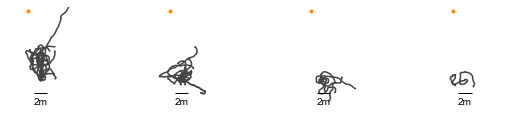

In [2]:
# This plots the whole DGPS trajectories without rediscritisation
show_labels = False
show_axis = False

# Conditions
conditions = ['FVNoIce', 'FVIce', 'ZVNoIce', 'ZVIce', 'treeFV'][:-1]
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=True, figsize=(column_full, column_full/5))

# Calculate actual position of the nest
nest_distance     = 10.5 # m
nest_heading_deg  = 100  # degrees
nest_heading_rads = np.radians(nest_heading_deg)
nest_x = nest_distance * np.cos(nest_heading_rads)
nest_y = nest_distance * np.sin(nest_heading_rads)

# Creat lists of the files
dict_files = {}
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob('../Ant_Cooling_Data/Converted_to_CSV/*' + condition + '*.csv')

# Plot only the DGPS recordings
recording_method_i = 1

# Plot the trajectories
for idx_i,condition in enumerate(conditions):
    if isinstance(axs, np.ndarray):
        if axs.ndim > 1:
            ax = axs[recording_method_i, idx_i]
            axs_row = axs[recording_method_i, :]
        else:
            ax = axs[idx_i]
            axs_row = axs
    else:
        ax = axs
        axs_row = axs

    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    # Get the sublist of filenames with the desired recording method string
    filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
    # If recording method is camera plot the grey circle
    if recording_method == 'fps':
        circ = plt.Circle((0, 0), 0.2, edgecolor='r', facecolor='#CCCCCC', linewidth=1.5, alpha=0.8)
        ax.add_patch(circ)
    else:
        pass
    
    # Plot the data in each of the filtered files
    for i,file in enumerate(filtered_files_list):
        pd_i = pd.read_csv(file)
        ax.plot(pd_i["x"], pd_i["y"], color='#444444', alpha=1)
    ax.axis('scaled')
    
    if recording_method == 'fps':
        ax.set_xlim([-0.25, 0.25])
        ax.set_ylim([-0.25, 0.25])
        draw_sizebar(ax, size=0.1, label='10cm', location='lower center')
    else:
        ax.set_xlim([-5, 5])
        ax.set_ylim([-5, 11])
        
        if condition == 'treeFV':
            ax.set_xlim([-5, 5])
            ax.set_ylim([-1, 12])
        
        draw_sizebar(ax, size=2.0, label='2m', location='lower center')
    
    # Plot the nest location
    ax.plot(nest_x, nest_y, '.', color='darkorange')
    
    # Beautify the axes
    if show_axis:
        adjust_spines(ax, ['left', 'bottom'], x_values=np.array([-5, 5]), y_values=np.array([-5, 10]), margin=1)
    else:
        ax.set_axis_off()
    
    if show_labels:
        ax.set_xlabel("x (m)")
        ax.set_ylabel("y (m)")
        ax.set_title(condition)
    
    ax.set_aspect('equal')
    ax.grid(color="0.9", linestyle='-', linewidth=1)

if save_figures:
    fig.savefig(images_path + 'ants_fullRelease_' + 'routes' + save_figures_as_filetype, bbox_inches='tight', transparent=True) # , pad_inches=0

## Plot the collected ant trajectories on the platform (camera recordings) with coloured depiction of time

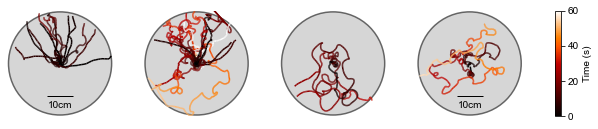

In [3]:
# Colour lines by time

show_labels = False
show_axis = False

# Conditions
conditions = ['FVNoIce', 'FVIce', 'ZVNoIce', 'ZVIce', 'treeFV'][:-1]
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

colormap='gist_heat'

fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=False, figsize=(column_full/4*len(conditions)+2, column_full/5))

# Creat lists of the files
dict_files = {}
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob(path_data + 'Converted_to_CSV/' + '*' + condition + '*.csv')

# Plot only the camera recordings
recording_method_i = 0

# Plot the ant trajectories
for idx_i,condition in enumerate(conditions):

    if isinstance(axs, np.ndarray):
        if axs.ndim > 1:
            ax = axs[recording_method_i, idx_i]
            axs_row = axs[recording_method_i, :]
        else:
            ax = axs[idx_i]
            axs_row = axs
    else:
        ax = axs
        axs_row = axs
    
    circ = plt.Circle((0, 0), 0.2, edgecolor='#444444', facecolor='#CCCCCC', linewidth=1.5, alpha=0.8)
    ax.add_patch(circ)
    
    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    # Get the sublist of filenames with the desired recording method string
    filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
    # Plot the data in each of the filtered files
    for file in filtered_files_list:
        # Load the ant trajectories
        pd_i = pd.read_csv(file)
        x = pd_i["x"]
        y = pd_i["y"]
        t = pd_i["Time"]

        # Create a set of line segments so that we can color them individually
        # This creates the points as a N x 1 x 2 array so that we can stack points
        # together easily to get the segments. The segments array for line collection
        # needs to be (numlines) x (points per line) x 2 (for x and y)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        # Create a continuous norm to map from data points to colors
        #norm = plt.Normalize(t.min(), t.max())
        # Sets the range of the t (colorbar) range
        norm = plt.Normalize(0, 60)
        lc = LineCollection(segments, cmap=colormap, norm=norm)
        # Set the values used for colormapping
        lc.set_array(t)

        line = ax.add_collection(lc)

    ax.set_aspect('equal')
    ax.set_xlim([-0.205, 0.205])
    ax.set_ylim([-0.205, 0.205])
    
    if show_axis:
        if idx_i == 0:
            adjust_spines(ax, ['left', 'bottom'], x_values=np.array([-0.2, 0.2]), y_values=np.array([-0.2, 0.2]), margin=1)
        else: 
            adjust_spines(ax, ['bottom'], x_values=np.array([-0.2, 0.2]), margin=1)
            ax.set_yticks([])
    else:
        ax.set_axis_off()
        if idx_i == 0 or idx_i == 3:
            draw_sizebar(ax, size=0.1, label='10cm', location='lower center')    
    
    if show_labels:
        ax.set_title(condition)
    
cbar = fig.colorbar(line, ax=axs_row.ravel().tolist())
cbar.ax.set_ylabel('Time (s)')

if save_figures:
    fig.savefig(images_path + 'ants_platformRelease_' + 'routes_time_coloured' + save_figures_as_filetype, bbox_inches='tight', transparent=True)

Conditions: 
 FVNoIce  FVIce  ZVNoIce  ZVIce 
FVNoIce: n=2752 FVIce: n=15961 ZVNoIce: n=1975 ZVIce: n=3023 

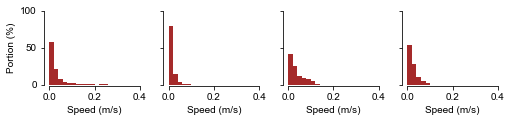

In [4]:
# Speed histograms on platform (r=20cm)
show_labels = False

conditions = ['FVNoIce', 'FVIce', 'ZVNoIce', 'ZVIce', 'treeFV'][:-1]
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

colour2 = 'brown'

fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=True, figsize=(column_210mm/4*len(conditions), column_210mm/6))

# Creat lists of the files
dict_files = {}
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob(path_data + 'Converted_to_CSV/' + '*' + condition + '*.csv')

# Use the camera recordings
recording_method_i = 0

print(('Conditions: \n' + ' {:} '*len(conditions)).format(*conditions))

# Plot the ant trajectories
for idx_i,condition in enumerate(conditions):
    
    v_set = np.array([])
    
    if isinstance(axs, np.ndarray):
        if axs.ndim > 1:
            ax = axs[recording_method_i, idx_i]
            axs_row = axs[recording_method_i, :]
        else:
            ax = axs[idx_i]
            axs_row = axs
    else:
        ax = axs
        axs_row = axs
    
    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    # Get the sublist of filenames with the desired recording method string
    filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
    # Plot the data in each of the filtered files
    for file in filtered_files_list:
        # Load the ant trajectories
        pd_i = pd.read_csv(file)
        x = pd_i["x"]
        y = pd_i["y"]
        t = pd_i["Time"]

        dx = np.diff(x)
        dy = np.diff(y)
        dh = np.hypot(dx, dy)
        dt = np.diff(t)
        
        v = dh / dt        
        v_set = np.append(v_set, v)
    
    weights = np.ones_like(v_set) / float(len(v_set)) * 100
    n, bins, _ = ax.hist(v_set, bins=20, range=[0,0.4], weights=weights, color=colour2) 
    
    print(condition + ': n=' + str(len(v_set)), end=' ')
    
    adjust_spines(ax, ['left', 'bottom'], x_values=np.array([0.0, 0.4]), y_values=np.array([0.0, 100]), margin=1)
    
    ax.set_ylim([0, 0.4])
    ax.set_ylim([0, 100])
    
    if idx_i == 0:
        ax.set_ylabel("Portion (%)")
    ax.set_xlabel("Speed (m/s)")

    if show_labels:
        ax.set_title(condition)    

if save_figures:
    fig.savefig(images_path + 'ants_platformRelease_' + 'speed_histograms' + save_figures_as_filetype, bbox_inches='tight', transparent=True)
    

Conditions: 
 FVNoIce  FVIce  ZVNoIce  ZVIce 
FVNoIce: n=13
FVIce: n=16
ZVNoIce: n=3
ZVIce: n=3


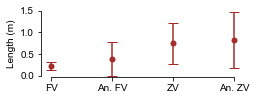

In [5]:
# Length of paths on the platform (r=20cm)

show_labels = False

conditions = ['FVNoIce', 'FVIce', 'ZVNoIce', 'ZVIce', 'treeFV'][:-1]
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

# Plot styling 
markersize=5
capsize=5

colour2 = 'brown'

condition_label = {
    'FVNoIce' : 'FV', 
    'FVIce'   : 'An. FV', 
    'ZVNoIce' : 'ZV', 
    'ZVIce'   : 'An. ZV'
}

def conditionsToLabels(lst):
    """ Gets a list of strings and returns a list of 
        the corresponding labels for printing """
    if not isinstance(lst, list):
        lst = [lst]
    return [condition_label[item] for item in lst]
    

fig = plt.figure(figsize=(column_double/2, column_double/3/2))
ax = plt.gca()

# Create lists of the files
dict_files = {}
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob(path_data + 'Converted_to_CSV/' + '*' + condition + '*.csv')

# Use the camera recordings
recording_method_i = 0

print(('Conditions: \n' + ' {:} '*len(conditions)).format(*conditions))

# Create dictionary to store the path lengths
traj_lengths = {}
traj_lengths['condition'] = []
traj_lengths['median'] = []
traj_lengths['sd'] = []

# Plot the ant trajectories
for idx_i,condition in enumerate(conditions):

    lengths_set = np.array([])
    
    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    # Get the sublist of filenames with the desired recording method string
    filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
    # Plot the data in each of the filtered files
    for file in filtered_files_list:
        # Load the ant trajectories
        pd_i = pd.read_csv(file)
        x = pd_i["x"]
        y = pd_i["y"]
        t = pd_i["Time"]
        
        # Find the first crossing of the 20cm radius
        h = np.hypot(x, y)
        indx_k = np.argmin(np.abs(h - 0.20))
        indx_k = min(indx_k+1, len(h))
        
        dx = np.diff(x[:indx_k])
        dy = np.diff(y[:indx_k])
        dh = np.hypot(dx, dy)
        length = np.sum(dh)
        lengths_set = np.append(lengths_set, length)

    traj_lengths['condition'].append(condition)
    traj_lengths['median'].append(np.median(lengths_set))
    traj_lengths['sd'].append(np.std(lengths_set))
    # Also store the individual path lengths samples for statistical significance calculation
    traj_lengths[condition] = lengths_set
    
    print(condition + ': n=' + str(len(lengths_set)))
    
ax.errorbar(x=np.arange(len(conditions))+1, y=traj_lengths['median'], yerr=traj_lengths['sd'], fmt='o', color=colour2, markersize=markersize, capsize=capsize)
ax.set_ylabel('Length (m)');
ax.set_xticks(np.arange(len(conditions))+1);
ax.set_xticklabels(conditionsToLabels(conditions));
ax.set_ylim([0, 1.5]);

adjust_spines(ax, ['left', 'bottom'], x_values=np.array([1, 4]), y_values=np.array([0, 1.5]), margin=1)

if save_figures:
    fig.savefig(images_path + 'ants_platformRelease_' + 'path_lengths' + save_figures_as_filetype, bbox_inches='tight', transparent=True)


## Plot the mean vectors of the trajectories


fps
           FVNoIce    FVIce    ZVNoIce    ZVIce   
Mean th (^o)    96.754   105.182   248.680   142.244
Mean theta     1.689     1.836     4.340     2.483
 SD theta      0.947     1.249     1.316     1.371
  Mean r       0.551     0.219     0.134     0.061

Circular uniformity test

              FVNoIce      FVIce      ZVNoIce      ZVIce    
   V test      0.000       0.000       0.912       0.326    
 V test(n)     13.000      16.000      3.000       3.000    


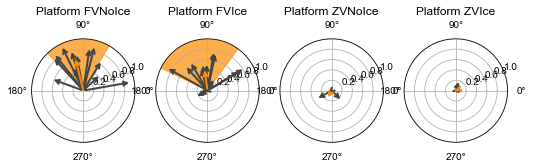

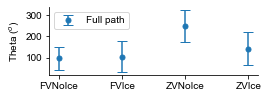

In [14]:
# Polar plots and heading angles

# Style the polar plots
arrowprops_mean_arrow = dict(color='#444444', linewidth=2, alpha=1.0)
arrowprops_all_arrow = dict(color='darkorange', linewidth=2, alpha=1.0)
arrowprops_all_arrow_2 = dict(color='darkorange', linewidth=2, alpha=1.0)
arrowprops_all_sector_2 = dict(color='darkorange', alpha=0.7)

# Conditions
conditions = ['FVNoIce', 'FVIce', 'ZVNoIce', 'ZVIce', 'treeFV'][:-1]
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}
recording_methods_names = ['Full path', 'First 20cm']
sampling_interval_step = 0.001

recording_method_i = 0

circ_stats_dic = {}

# Create lists of the files
dict_files = {}
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob('../Ant_Cooling_Data/Converted_to_CSV_rediscretisised/*' + condition + '*.csv')

fig, axs = plt.subplots(1, len(conditions), figsize=(column_full/1.14, column_full/1.14/1.5/2), subplot_kw=dict(polar=True))
fig2, axs2_ = plt.subplots(1, 1, figsize=(column_full/2/1.3, column_full/2/1.3/3)); axs2 = [axs2_, axs2_];

data_thetas = {}
data_mean_thetas = {}
for recording_method_i in range(0,1):
    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    circ_stats_dic[recording_method] = {}
    #circ_stats_dic2[recording_method] = {}
    data_thetas[recording_method] = {}
    data_mean_thetas[recording_method] = {}
    for plt_i,condition in enumerate(conditions):
        circ_stats_dic[recording_method][condition] = {}
        #circ_stats_dic2[recording_method][condition] = {}
        ax = axs[plt_i]
        # Get the sublist of filenames with the desired recording method string
        filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
        # Get the sublist of filenames with the desired rediscritization length
        filtered_files_list = [string for string in filtered_files_list if str(sampling_interval_step).replace('.', '_') in string]
        dx_array = np.array([])
        dy_array = np.array([])
        vector_r_mean_array     = np.array([])
        vector_theta_mean_array = np.array([])
        
        # Plot the data in each of the filtered files
        for file in filtered_files_list:
            pd_i = pd.read_csv(file)
            dx = np.diff(pd_i["x"])
            dy = np.diff(pd_i["y"])
            theta = np.arctan2(dy, dx) # The angle of the vector
            theta[theta<0] += 2*np.pi # Convert all angles to be only positive 0 to 2*pi
            r = np.sqrt(dx**2 + dy**2) # The length of the vector
            # Some redundant calculations used to check if all methods use the same results
            theta_mean = scipy.stats.circmean(theta) ####
            r_mean = circ_r_xy(dx, dy)
            r_mean = circ_r_alpha(theta)
            dx_array = np.append(dx_array, dx)
            dy_array = np.append(dy_array, dy)
            vector_r_mean_array     = np.append(vector_r_mean_array, r_mean)
            vector_theta_mean_array = np.append(vector_theta_mean_array, theta_mean) ####
            
            # Plot one vectors per trajectory
            compass([r_mean*np.cos(theta_mean)], [r_mean*np.sin(theta_mean)], ax, arrowprops=arrowprops_mean_arrow)
        
        theta_array = np.arctan2(dy_array, dx_array) ####
        theta_array[theta_array<0] += 2*np.pi
        data_thetas[recording_method][condition] = theta_array
        data_mean_thetas[recording_method][condition] = vector_theta_mean_array
        r_array = np.sqrt(dx_array**2 + dy_array**2)
        theta_mean_array = scipy.stats.circmean(theta_array) ####
        theta_std_array = scipy.stats.circstd(theta_array)
        theta_std_array = astropy.stats.circstats.circstd(theta_array)
        r_mean_array = circ_r_xy(dx_array, dy_array)
        r_mean_array = circ_r_alpha(theta_array)
        
        vector_x_mean = np.median(vector_r_mean_array*np.cos(vector_theta_mean_array))
        vector_y_mean = np.median(vector_r_mean_array*np.sin(vector_theta_mean_array))
        vector_angle_mean = scipy.stats.circmean(vector_theta_mean_array) ####
        vector_angle_std = scipy.stats.circstd(vector_theta_mean_array)
        vector_angle_std = astropy.stats.circstats.circstd(vector_theta_mean_array)
        
        compass([vector_x_mean], [vector_y_mean], ax, arrowprops=arrowprops_all_arrow_2)
        # Plot the orange sector
        if condition in ['FVNoIce', 'FVIce']:
            compass_sector_pol(vector_angle_mean-vector_angle_std, vector_angle_mean+vector_angle_std, 1.0, ax, sectorprops=arrowprops_all_sector_2)
        
        ax.set_rmax(1) # Sets the radius of the plot
        ax.set_xticks(np.pi/180. * np.linspace(0,  360, 4, endpoint=False))
        
        if recording_method_i == 0:
            ax.set_title("Platform " + condition)
        else:
            ax.set_title("Long range " + condition)
        circ_stats_dic[recording_method][condition]["theta_mean"] = theta_mean_array
        circ_stats_dic[recording_method][condition]["theta_std"] = theta_std_array
        circ_stats_dic[recording_method][condition]["r_mean"] = r_mean_array
        
    # Print the stats
    theta_mean_list = ['Mean theta']
    theta_mean_deg_list = ['Mean th (^o)']
    theta_std_list = ['SD theta']
    r_mean_list = ['Mean r']
    header_format_placeholder = '{:^10s}' * (len(conditions)+1)
    row_format_placeholder = '{:^10s}' + '{:10.3f}' * len(conditions)
    print()
    print(recording_method)
    print(header_format_placeholder.format(*([''] + conditions)))
    for plt_i,condition in enumerate(conditions):
        theta_mean_list.append(circ_stats_dic[recording_method][condition]["theta_mean"])
        theta_mean_deg_list.append(np.degrees(circ_stats_dic[recording_method][condition]["theta_mean"]))
        theta_std_list.append(circ_stats_dic[recording_method][condition]["theta_std"])
        r_mean_list.append(circ_stats_dic[recording_method][condition]["r_mean"])

    # Print the stats
    print(row_format_placeholder.format(*theta_mean_deg_list))
    print(row_format_placeholder.format(*theta_mean_list))
    print(row_format_placeholder.format(*theta_std_list))
    print(row_format_placeholder.format(*r_mean_list))

    # Plot the stats
    ax = axs2[recording_method_i]
    ax.errorbar(x=np.arange(len(conditions))+1, y=np.degrees(theta_mean_list[1:]), yerr=np.degrees(theta_std_list[1:]), fmt='o', markersize=5, capsize=5, label=recording_methods_names[recording_method_i]) # linewidth=2.5, 
    ax.set_ylabel('Theta ($^o$)');
    ax.set_xticks(np.arange(len(conditions))+1);
    ax.set_xticklabels(conditions);
    ax.legend()
    
    print('')
    print('Circular uniformity test')
    circ_stat_tests(data=data_mean_thetas[recording_method])


if save_figures:
    fig.savefig(images_path + 'ants_platformAndfullRelease_' + 'routes_polar_vectors' + save_figures_as_filetype, bbox_inches='tight', transparent=True)
    fig2.savefig(images_path + 'ants_platformAndfullRelease_' + 'mean_and_sd_theta' + save_figures_as_filetype, bbox_inches='tight', transparent=True)


## How long does it take for ants to cross the 20cm radius platform


Mann-Whitney U
              FVNoIce      FVIce      ZVNoIce      ZVIce    
  FVNoIce      0.490       0.002       0.005       0.016    
   FVIce       0.002       0.492       0.348       0.234    
  ZVNoIce      0.005       0.348       0.410       0.331    
   ZVIce       0.016       0.234       0.331       0.410    

           FVNoIce     FVIce       ZVNoIce     ZVIce      
   Mean    8.436923076923078  28.765333333333334  26.253333333333334  38.973333333333336 
    SD     5.902770385577612  21.39778862925378  3.915144385020246  19.641108816855414 



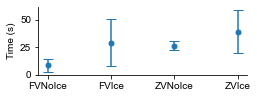

In [12]:
# Plot the time to cross the platform circumferance

# Conditions
conditions = ['FVNoIce', 'FVIce', 'ZVNoIce', 'ZVIce', 'treeFV'][:-1]
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

# Which types of plots to use can be one of the two or both
plot_type = ['barplot', 'errorplot', 'dont_show_outliers'][1:]

# Use the camera recordings
recording_methods_num = 1

dict_files = {}
dict_crossing_time = {}
dict_crossing_time_stats = {}

# Creat lists of the files
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob(path_data + 'Converted_to_CSV/' + '*' + condition + '*.csv')

# Calculate the platform radius crossing time
for condition in conditions:
    dict_crossing_time[condition] = {}
    for recording_method_i in range(0,recording_methods_num):
        # Get recording method string used in file names
        recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
        # Get the sublist of filenames with the desired recording method string
        filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
        list_of_t_measurements = []
        # Plot the data in each of the filtered files
        for file in filtered_files_list:
            pd_i = pd.read_csv(file)
            x = pd_i["x"] - pd_i["x"][0]
            y = pd_i["y"] - pd_i["y"][0]
            h = np.hypot(x, y)
            
            t = pd_i["Time"]
            #cross_t = t[np.argmax(h>0.2)] # The problem with this is that for the ants that never cross the 0.2m it returns 0s
            cross_t = t[np.argmin(np.abs(h-0.2))] # This approach returns the nearest value at the 0.2m even if they do not cross it.
            list_of_t_measurements.append(cross_t)
        dict_crossing_time[condition][recording_method] = np.array(list_of_t_measurements)

# Calculate the time stats
for condition in conditions:
    dict_crossing_time_stats[condition] = {}
    for recording_method_i in range(0,recording_methods_num):
        # Get recording method string used in file names
        recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
        data_points = dict_crossing_time[condition][recording_method]
        dict_crossing_time_stats[condition][recording_method] = {}
        dict_crossing_time_stats[condition][recording_method]['median'] = np.median(data_points)
        dict_crossing_time_stats[condition][recording_method]['std'] = np.std(data_points)

# Test statistical significance of means difference
data = {}
for recording_method_i in range(0,recording_methods_num):
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    for condition in conditions:
        data[condition] = dict_crossing_time[condition][recording_method]
    stat_tests(data=data)

# Plot the boxplot
fig, ax = plt.subplots(1, 1, figsize=(column_full/2/1.3, column_full/2/1.3/3))

# Prepare the data
for recording_method_i in range(0,recording_methods_num):
    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    data_list = []
    for i, condition in enumerate(conditions):
        data_list.append(dict_crossing_time[condition][recording_method])

if 'barplot' in plot_type:
    bp = ax.boxplot(data_list, labels=conditions)
    # Set the colour of thew boxes
    for b_i, b in enumerate(bp['boxes']):
        bp["medians"][b_i].set_color('black')
    ax.set_xlabel('Condition');
    ax.set_ylabel('Time (s)');

if 'errorplot' in plot_type:
    m = []
    sd = []
    outliers = []
    for idx_i,d in enumerate(data_list):
        d_without_outliers, d_outliers = reject_outliers(d)
        m.append(np.mean(d_without_outliers))
        sd.append(np.std(d_without_outliers))
        outliers.append(d_outliers)
        if 'show_outliers' in plot_type and len(d_outliers):
            ax.scatter([idx_i+1]*len(d_outliers), d_outliers)
    ax.errorbar(x=np.arange(len(conditions))+1, y=m, yerr=sd, fmt='o', markersize=5, capsize=5)
    #ax.set_xlabel('Condition');
    ax.set_ylabel('Time (s)');
    ax.set_xticks(np.arange(len(conditions))+1);
    ax.set_xticklabels(conditions);

    print()
    print(('          ' + ' {:10} ' * len(conditions)).format(*conditions))
    print(('   Mean   ' + ' {:10} ' * len(conditions)).format(*m))
    print(('    SD    ' + ' {:10} ' * len(conditions)).format(*sd))
    print()

if save_figures:
    fig.savefig(images_path + 'ants_platformRelease_' + 'time_within_20cm' + save_figures_as_filetype, bbox_inches='tight', transparent=True)


## Plot the collected ant trajectories for the Tree release conditions

Conditions: 
 tree-FV-NoIce  tree-FV-Ice  tree-NoIce-ZV-ReRelease  tree-Ice-ZV-ReRelease 


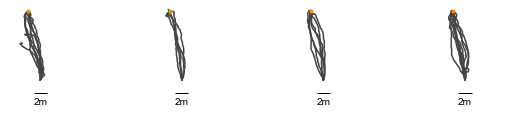

In [17]:
# This plots the whole DGPS trajectories without rediscritisation
show_labels = False
show_axis = False

# Conditions
conditions = ['tree-FV-NoIce', 'tree-FV-Ice', 'tree-NoIce-ZV-ReRelease', 'tree-Ice-ZV-ReRelease']
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=True, figsize=(column_full, column_full/5))

# Calculate actual position of the nest
nest_distance     = 10.5 # m
nest_heading_deg  = 100  # degrees
nest_heading_rads = np.radians(nest_heading_deg)
nest_x = nest_distance * np.cos(nest_heading_rads)
nest_y = nest_distance * np.sin(nest_heading_rads)

# Create lists of the files
dict_files = {}
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob('../Ant_Cooling_Data/Converted_to_CSV/*' + condition + '*.csv')

# Use the DGPS recordings
recording_method_i = 1

print(('Conditions: \n' + ' {:} '*len(conditions)).format(*conditions))

# Plot the trajectories
for idx_i,condition in enumerate(conditions):
    if isinstance(axs, np.ndarray):
        if axs.ndim > 1:
            ax = axs[recording_method_i, idx_i]
            axs_row = axs[recording_method_i, :]
        else:
            ax = axs[idx_i]
            axs_row = axs
    else:
        ax = axs
        axs_row = axs

    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    # Get the sublist of filenames with the desired recording method string
    filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
    # Get the sublist of filenames with the desired rediscritization length
    if recording_method == 'fps':
        circ = plt.Circle((0, 0), 0.2, edgecolor='r', facecolor='#CCCCCC', linewidth=1.5, alpha=0.8)
        ax.add_patch(circ)
    else:
        pass
    
    # Plot the data in each of the filtered files
    for i,file in enumerate(filtered_files_list):
        pd_i = pd.read_csv(file)
        ax.plot(pd_i["x"], pd_i["y"], color='#444444', alpha=1)
    ax.axis('scaled')
    
    if recording_method == 'fps':
        ax.set_xlim([-0.25, 0.25])
        ax.set_ylim([-0.25, 0.25])
        draw_sizebar(ax, size=0.1, label='10cm', location='lower center')
    else:
        ax.set_xlim([-5, 5])
        ax.set_ylim([-5, 11])
        if condition == 'treeFV':
            ax.set_xlim([-5, 5])
            ax.set_ylim([-1, 12])
        draw_sizebar(ax, size=2.0, label='2m', location='lower center')
    
    # Plot the nest location
    ax.plot(nest_x, nest_y, '.', color='darkorange')
    
    # Beautify the axes
    if show_axis:
        adjust_spines(ax, ['left', 'bottom'], x_values=np.array([-5, 5]), y_values=np.array([-5, 10]), margin=1)
    else:
        ax.set_axis_off()
    
    if show_labels:
        ax.set_xlabel("x (m)")
        ax.set_ylabel("y (m)")
        ax.set_title(condition)
    ax.set_aspect('equal')
    ax.grid(color="0.9", linestyle='-', linewidth=1)

if save_figures:
    fig.savefig(images_path + 'ants_fullRelease_' + 'atTree_' + 'routes' + save_figures_as_filetype, bbox_inches='tight', transparent=True) # , pad_inches=0

Conditions: 
 tree-FV-NoIce  tree-FV-Ice  tree-NoIce-ZV-ReRelease  tree-Ice-ZV-ReRelease 
tree-FV-NoIce: n=784 tree-FV-Ice: n=5334 tree-NoIce-ZV-ReRelease: n=11509 tree-Ice-ZV-ReRelease: n=11611 

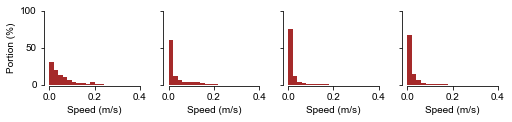

In [18]:
# Speed histogram on platform for the Tree release conditions (r=20cm)

show_labels = False

# Conditions
conditions = ['tree-FV-NoIce', 'tree-FV-Ice', 'tree-NoIce-ZV-ReRelease', 'tree-Ice-ZV-ReRelease']
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

colour2 = 'brown'

fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=True, figsize=(column_210mm/4*len(conditions), column_210mm/6))

# Create lists of the files
dict_files = {}
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob(path_data + 'Converted_to_CSV/' + '*' + condition + '*.csv')

# Use the camera recordings
recording_method_i = 0

print(('Conditions: \n' + ' {:} '*len(conditions)).format(*conditions))

# Plot the ant trajectories
for idx_i,condition in enumerate(conditions):
    
    v_set = np.array([])
    
    if isinstance(axs, np.ndarray):
        if axs.ndim > 1:
            ax = axs[recording_method_i, idx_i]
            axs_row = axs[recording_method_i, :]
        else:
            ax = axs[idx_i]
            axs_row = axs
    else:
        ax = axs
        axs_row = axs
    
    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    # Get the sublist of filenames with the desired recording method string
    filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
    # Plot the data in each of the filtered files
    for file in filtered_files_list:
        # Load the ant trajectories
        pd_i = pd.read_csv(file)
        x = pd_i["x"]
        y = pd_i["y"]
        t = pd_i["Time"]

        dx = np.diff(x)
        dy = np.diff(y)
        dh = np.hypot(dx, dy)
        dt = np.diff(t)
        
        v = dh / dt        
        v_set = np.append(v_set, v)
    
    weights = np.ones_like(v_set) / float(len(v_set)) * 100
    n, bins, _ = ax.hist(v_set, bins=20, range=[0,0.4], weights=weights, color=colour2) 
    #print(len(n), bins)
    
    print(condition + ': n=' + str(len(v_set)), end=' ')
    
    adjust_spines(ax, ['left', 'bottom'], x_values=np.array([0.0, 0.4]), y_values=np.array([0.0, 100]), margin=1)
    
    ax.set_ylim([0, 0.4])
    ax.set_ylim([0, 100])
    
    if idx_i == 0:
        ax.set_ylabel("Portion (%)")
    ax.set_xlabel("Speed (m/s)")

    if show_labels:
        ax.set_title(condition)    

if save_figures:
    fig.savefig(images_path + 'ants_platformRelease_' + 'atTree_' + 'speed_histograms' + save_figures_as_filetype, bbox_inches='tight', transparent=True)


Conditions: 
 tree-FV-NoIce  tree-FV-Ice  tree-NoIce-ZV-ReRelease  tree-Ice-ZV-ReRelease 
tree-FV-NoIce: n=8
tree-FV-Ice: n=7
tree-NoIce-ZV-ReRelease: n=6
tree-Ice-ZV-ReRelease: n=9


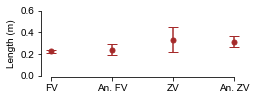

In [19]:
# Path length on platform for Tree releases(r=20cm)

show_labels = False

# Conditions
conditions = ['tree-FV-NoIce', 'tree-FV-Ice', 'tree-NoIce-ZV-ReRelease', 'tree-Ice-ZV-ReRelease']
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

# Plot styling
markersize=5
capsize=5

colour2 = 'brown'

condition_label = {
    'FVNoIce' : 'FV', 
    'FVIce'   : 'An. FV', 
    'ZVNoIce' : 'ZV', 
    'ZVIce'   : 'An. ZV',
    'tree-FV-NoIce'           : 'FV',
    'tree-FV-Ice'             : 'An. FV', 
    'tree-NoIce-ZV-ReRelease' : 'ZV', 
    'tree-Ice-ZV-ReRelease'   : 'An. ZV'
}

def conditionsToLabels(lst):
    """ Gets a list of strings and returns a list of 
    the corresponding labels for printing """
    if not isinstance(lst, list):
        lst = [lst]
    return [condition_label[item] for item in lst]
    

fig = plt.figure(figsize=(column_double/2, column_double/3/2))
ax = plt.gca()

# Create lists of the files
dict_files = {}
for condition in conditions:
    dict_files[condition] = {}
    dict_files[condition] = glob.glob(path_data + 'Converted_to_CSV/' + '*' + condition + '*.csv')

# use the camera recordings
recording_method_i = 0

print(('Conditions: \n' + ' {:} '*len(conditions)).format(*conditions))

# Dictionary for storing the path lengths
traj_lengths = {}
traj_lengths['condition'] = []
traj_lengths['median'] = []
traj_lengths['sd'] = []

# Plot the ant trajectories
for idx_i,condition in enumerate(conditions):

    lengths_set = np.array([])    

    # Get recording method string used in file names
    recording_method = recording_methods_keywords[recording_methods[recording_method_i]]
    # Get the sublist of filenames with the desired recording method string
    filtered_files_list = [string for string in dict_files[condition] if recording_method in string]
    # Plot the data in each of the filtered files
    for file in filtered_files_list:
        # Load the ant trajectories
        pd_i = pd.read_csv(file)
        x = pd_i["x"]
        y = pd_i["y"]
        t = pd_i["Time"]
        
        # Find the first crossing of the 20cm radius
        h = np.hypot(x, y)
        indx_k = np.argmin(np.abs(h - 0.20))
        indx_k = min(indx_k+1, len(h))
        
        dx = np.diff(x[:indx_k])
        dy = np.diff(y[:indx_k])
        dh = np.hypot(dx, dy)
        length = np.sum(dh)
        lengths_set = np.append(lengths_set, length)

    traj_lengths['condition'].append(condition)
    traj_lengths['median'].append(np.median(lengths_set))
    traj_lengths['sd'].append(np.std(lengths_set))
    
    # Also store the individual path lengths samples for statistical significance calculation
    traj_lengths[condition] = lengths_set
    
    print(condition + ': n=' + str(len(lengths_set)))
    
ax.errorbar(x=np.arange(len(conditions))+1, y=traj_lengths['median'], yerr=traj_lengths['sd'], fmt='o', color=colour2, markersize=markersize, capsize=capsize)
ax.set_ylabel('Length (m)');
ax.set_xticks(np.arange(len(conditions))+1);
ax.set_xticklabels(conditionsToLabels(conditions));
ax.set_ylim([0,0.6]);
adjust_spines(ax, ['left', 'bottom'], x_values=np.array([1, 4]), y_values=np.array([0.0, 0.6]), margin=1)

if save_figures:
    fig.savefig(images_path + 'ants_platformRelease_' + 'atTree_' + 'path_lengths' + save_figures_as_filetype, bbox_inches='tight', transparent=True)


## Plot trajectories of simulated agents

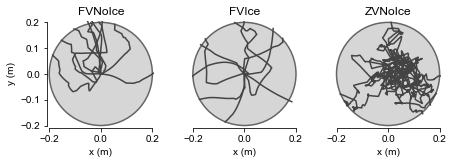

In [22]:
# Plots the simulated agents paths within the first 20cm for all conditions
path = 'Simulation/path-integration-forget/data/Converted_to_CSV/Conditions/Memory/'

# Conditions
conditions = ['FVNoIce', 'FVIce', 'ZVNoIce']
recording_methods = ["camera", "DGPS"]
recording_methods_keywords = {"camera": "fps", "DGPS": "gps"}

# Use the within 20cm recordings
recording_method_i = 0

fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=False, figsize=(column_full/4*len(conditions), column_full/5))

# Plot the trajectories of simulated agent
# ----------------------------------------
# Plot the simulated trajectories
for idx_i,condition in enumerate(conditions):
    ax = axs[idx_i]
    axs_row = axs

    circ = plt.Circle((0, 0), 0.2, edgecolor='#444444', facecolor='#CCCCCC', linewidth=1.5, alpha=0.8)
    ax.add_patch(circ)
    
    start = 1015
    num = 10
    noise_syn=0.1
    noise_rot = 7.0
    noiseSlope = 9.0
    sampling_rate = 25
    plot_npz_or_csv = 'csv' # 'npz' or 'csv' which files to use original or preprocessed
    condition_sim = condition
    if condition_sim == 'FVNoIce':
        condition_sim = 'FV'
    if condition_sim == 'ZVNoIce':
        condition_sim = 'FVIce=0.5'
    if condition_sim == 'FVIce':
        condition_sim = 'FVIce-0.35'
    for i in range(start, start+num):
        filename = path + condition_sim + '/with_Pontin_Holonomic_noiseSyn' + str(noise_syn) + '_noiseRot' + str(noise_rot) + '_noiseSlope' + str(noiseSlope) + '_route_' + condition_sim + '_' + str(i) + '.npz'

        # If we are using the already processed files (data/Converted_to_CSV/)
        if plot_npz_or_csv == 'csv':
            # Load instead the csv converted files that have only the first portion of the routes until they cross the 20cm radius
            filename_csv = filename.replace('.npz', '_platformReleases.csv')

            # Plot the already converted to csv files cut off at 20cm radius from release point in red
            pd_i = pd.read_csv(filename_csv)
            x = pd_i["x"]
            y = pd_i["y"]
            t = pd_i["Time"]
            ax.plot(x, y, color='#444444', alpha=1.0)
    
    ax.set_aspect('equal')
    ax.set_xlim([-0.205, 0.205])
    ax.set_ylim([-0.205, 0.205])
    
    # Style the plots
    if idx_i == 0:
        adjust_spines(ax, ['left', 'bottom'], x_values=np.array([-0.2, 0.2]), y_values=np.array([-0.2, 0.2]), margin=1)
    else: 
        adjust_spines(ax, ['bottom'], x_values=np.array([-0.2, 0.2]), margin=1)
        ax.set_yticks([])
    
    ax.set_xlabel("x (m)")
    if idx_i == 0:
        ax.set_ylabel("y (m)")
    ax.set_title(condition)

if save_figures:
    fig.savefig(images_path + 'simulated_platformRelease_' + 'routes' + save_figures_as_filetype, bbox_inches='tight', transparent=True)

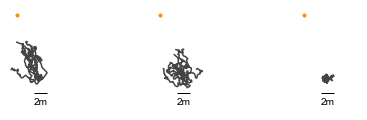

In [23]:
# Plots the full trajectories of simulated agents for all conditions

path = 'Simulation/path-integration-forget/data/Converted_to_CSV/Conditions/Memory/'

show_labels = False
show_axis = False

# Conditions
conditions = ['FVNoIce', 'FVIce', 'ZVNoIce']

fig, axs = plt.subplots(1, len(conditions), sharex=True, sharey=False, figsize=(column_full/4*len(conditions), column_full/5))

# Calculate actual position of the nest
nest_distance     = 10.5 # m
nest_heading_deg  = 110 # degrees
nest_heading_rads = np.radians(nest_heading_deg)
nest_x = nest_distance * np.cos(nest_heading_rads)
nest_y = nest_distance * np.sin(nest_heading_rads)

# Plot the trajectories of simulated agent
# ----------------------------------------
# Plot the simulated trajectories
for idx_i,condition in enumerate(conditions):
    ax = axs[idx_i]
    axs_row = axs

    start = 1010
    num = 10
    noise_syn=0.1
    noise_rot = 7.0
    noiseSlope = 9.0
    sampling_rate = 25
    plot_npz_or_csv = 'csv' # 'npz' or 'csv' which files to use original or preprocessed
    condition_sim = condition
    if condition_sim == 'FVNoIce':
        condition_sim = 'FV'
    if condition_sim == 'ZVNoIce':
        condition_sim = 'FVIce=0.5'
        condition_sim = 'ZV'
    if condition_sim == 'FVIce':
        condition_sim = 'FVIcex0.85'
    for i in range(start, start+num):
        filename = path + condition_sim + '/with_Pontin_Holonomic_noiseSyn' + str(noise_syn) + '_noiseRot' + str(noise_rot) + '_noiseSlope' + str(noiseSlope) + '_route_' + condition_sim + '_' + str(i) + '.npz'
        
        # If we use the already processed files (data/Converted_to_CSV/)
        if plot_npz_or_csv == 'csv':
            filename_csv = filename.replace('.npz', '.csv')            
            pd_i = pd.read_csv(filename_csv)
            x = pd_i["x"]
            y = pd_i["y"]
            x = x * 3
            y = y * 3
            ax.plot(x, y, color='#444444', alpha=1.0)
    
    ax.axis('scaled')
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 11])
    draw_sizebar(ax, size=2.0, label='2m', location='lower center')
    
    # Plot the nest location
    ax.plot(nest_x, nest_y, '.', color='darkorange')

    # Beautify the axes
    if show_axis:
        adjust_spines(ax, ['left', 'bottom'], x_values=np.array([-5, 5]), y_values=np.array([-5, 10]), margin=1)
    else:
        ax.set_axis_off()
    
    if show_labels:
        ax.set_xlabel("x (m)")
        if idx_i == 0:
            ax.set_ylabel("y (m)")
    
    if show_labels:
        ax.set_title(condition)

    ax.set_aspect('equal')
    ax.grid(color="0.9", linestyle='-', linewidth=1)

if save_figures:
    fig.savefig(images_path + 'simulated_fullRelease_' + 'routes' + save_figures_as_filetype, bbox_inches='tight', transparent=True) # , pad_inches=0

## Print and plot the path characteristic measures for the ant paths


Recording method: camera , Sampling intervals (m): 0.02 , File: stats_fps_step0.020m.csv


,EDiffusionDistance,ESqDiffusionDistance,Emax_a,Emax_a_unrediscretised,Emax_b,Emax_b_100deg,Emax_b_unrediscretised,TrajExpDrift,TrajExpDriftDist,TrajNestNearest,Unnamed: 0,mean_speed,min_C,min_deltaS,sd_speed,sinuosity,sinuosity_redisc,sinuosity_smooth_redisc,straightness_DL_ratio,straightness_r
condition,,,,,,,,,,,,,,,,,,,,
FVIce,0.057902,0.004360,15.906937,8.475682,0.318139,0.037685,0.009488,0.677025,0.054162,10.856112,21.5,0.024662,0.559584,1.0,0.038237,19.767604,5.820340,5.772392,0.690276,0.687513
FVNoIce,0.063823,0.005242,14.168330,8.721148,0.283367,0.116940,0.026905,0.829444,0.066356,10.850800,7.0,0.055583,NaN,NaN,0.047577,13.272741,3.927758,3.763897,0.866013,0.839456
ZVIce,0.053535,0.003668,1.474639,14.366930,0.029493,0.002996,0.015209,0.569840,0.045587,10.906646,34.0,0.026417,NaN,NaN,0.021738,11.615593,7.389782,7.351989,0.180268,0.585290
ZVNoIce,0.054714,0.003840,1.837826,13.164320,0.036757,-0.003062,0.025423,0.600595,0.048048,10.942387,31.0,0.038238,NaN,NaN,0.028028,11.771789,7.026914,7.048168,0.357045,0.613055


Emax_b
--------------------------------------------------------------------------------
stats_fps_step0.020m.csv
                 FVNoIce                FVIce                ZVNoIce                ZVIce         
Median      0.295257465729703     0.0268466040291783    0.0253730461967362    0.0272578229438287  
SD         0.23582902963980523   0.15973204957610238   0.021587664509003856  0.012407302415902953 

Recording method: DGPS , Sampling intervals (m): 0.1 , File: stats_gps_step0.100m.csv


,EDiffusionDistance,ESqDiffusionDistance,Emax_a,Emax_a_unrediscretised,Emax_b,Emax_b_100deg,Emax_b_unrediscretised,TrajExpDrift,TrajExpDriftDist,TrajNestNearest,Unnamed: 0,mean_speed,min_C,min_deltaS,sd_speed,sinuosity,sinuosity_redisc,sinuosity_smooth_redisc,straightness_DL_ratio,straightness_r
condition,,,,,,,,,,,,,,,,,,,,
FVIce,0.334634,0.142843,16.996661,5.379035,1.699666,0.054344,0.311749,0.907829,0.363131,9.756321,24.5,1.240450,NaN,NaN,0.665852,3.131616,1.319593,1.070339,0.516317,0.929083
FVNoIce,0.345872,0.152355,32.298259,10.041187,3.229826,0.153211,0.645171,0.960678,0.384271,7.566437,8.5,1.542917,NaN,NaN,0.593714,1.987354,0.861351,0.572549,0.577596,0.963722
ZVIce,0.337387,0.144941,12.024977,6.236122,1.202498,-0.011027,0.286701,0.921620,0.368648,9.927593,39.5,1.147006,NaN,NaN,0.479702,2.538210,1.274314,0.994367,0.255351,0.925009
ZVNoIce,0.338625,0.146112,16.533296,8.280490,1.653330,-0.014533,0.496676,0.927000,0.370800,10.488474,35.5,1.466552,0.871364,12.0,0.520574,2.063284,1.190124,0.915084,0.451625,0.929925


Emax_b
--------------------------------------------------------------------------------
stats_gps_step0.100m.csv
                 FVNoIce                FVIce                ZVNoIce                ZVIce         
Median       3.15302582218356      1.03176102312622     1.6275036432144399     1.20249773396948   
SD          1.4325383352300423   0.44875311086868297    0.7144758119095183   0.18637133480715007  

Statistical significance of two sample means of path lengths:

Mann-Whitney U
              FVNoIce      FVIce      ZVNoIce      ZVIce    
  FVNoIce      0.492       0.002       0.012       0.040    
   FVIce       0.002       0.492       0.219       0.472    
  ZVNoIce      0.012       0.219       0.468       0.202    
   ZVIce       0.040       0.472       0.202       0.333    

Recording method: camera , Sampling intervals (m): 0.02 , File: stats_fps_step0.020m.csv


,EDiffusionDistance,ESqDiffusionDistance,Emax_a,Emax_a_unrediscretised,Emax_b,Emax_b_100deg,Emax_b_unrediscretised,TrajExpDrift,TrajExpDriftDist,TrajNestNearest,Unnamed: 0,mean_speed,min_C,min_deltaS,sd_speed,sinuosity,sinuosity_redisc,sinuosity_smooth_redisc,straightness_DL_ratio,straightness_r
condition,,,,,,,,,,,,,,,,,,,,
FVIce,0.057902,0.004360,15.906937,8.475682,0.318139,0.037685,0.009488,0.677025,0.054162,10.856112,21.5,0.024662,0.559584,1.0,0.038237,19.767604,5.820340,5.772392,0.690276,0.687513
FVNoIce,0.063823,0.005242,14.168330,8.721148,0.283367,0.116940,0.026905,0.829444,0.066356,10.850800,7.0,0.055583,NaN,NaN,0.047577,13.272741,3.927758,3.763897,0.866013,0.839456
ZVIce,0.053535,0.003668,1.474639,14.366930,0.029493,0.002996,0.015209,0.569840,0.045587,10.906646,34.0,0.026417,NaN,NaN,0.021738,11.615593,7.389782,7.351989,0.180268,0.585290
ZVNoIce,0.054714,0.003840,1.837826,13.164320,0.036757,-0.003062,0.025423,0.600595,0.048048,10.942387,31.0,0.038238,NaN,NaN,0.028028,11.771789,7.026914,7.048168,0.357045,0.613055


Emax_b_100deg
--------------------------------------------------------------------------------
stats_fps_step0.020m.csv
                 FVNoIce                FVIce                ZVNoIce                ZVIce         
Median      0.0470660959365058    0.0289277913927777   -0.0032046822250189   -0.0001055093088228  
SD         0.05282091522429156   0.034739456518125794  0.0014073200527677675  0.004421915321972047 

Recording method: DGPS , Sampling intervals (m): 0.1 , File: stats_gps_step0.100m.csv


,EDiffusionDistance,ESqDiffusionDistance,Emax_a,Emax_a_unrediscretised,Emax_b,Emax_b_100deg,Emax_b_unrediscretised,TrajExpDrift,TrajExpDriftDist,TrajNestNearest,Unnamed: 0,mean_speed,min_C,min_deltaS,sd_speed,sinuosity,sinuosity_redisc,sinuosity_smooth_redisc,straightness_DL_ratio,straightness_r
condition,,,,,,,,,,,,,,,,,,,,
FVIce,0.334634,0.142843,16.996661,5.379035,1.699666,0.054344,0.311749,0.907829,0.363131,9.756321,24.5,1.240450,NaN,NaN,0.665852,3.131616,1.319593,1.070339,0.516317,0.929083
FVNoIce,0.345872,0.152355,32.298259,10.041187,3.229826,0.153211,0.645171,0.960678,0.384271,7.566437,8.5,1.542917,NaN,NaN,0.593714,1.987354,0.861351,0.572549,0.577596,0.963722
ZVIce,0.337387,0.144941,12.024977,6.236122,1.202498,-0.011027,0.286701,0.921620,0.368648,9.927593,39.5,1.147006,NaN,NaN,0.479702,2.538210,1.274314,0.994367,0.255351,0.925009
ZVNoIce,0.338625,0.146112,16.533296,8.280490,1.653330,-0.014533,0.496676,0.927000,0.370800,10.488474,35.5,1.466552,0.871364,12.0,0.520574,2.063284,1.190124,0.915084,0.451625,0.929925


Emax_b_100deg
--------------------------------------------------------------------------------
stats_gps_step0.100m.csv
                 FVNoIce                FVIce                ZVNoIce                ZVIce         
Median      0.0600632623424949    0.0174183380698823   -0.0240606366865208    -0.011026657077781  
SD         0.04987695857567853   0.06342166645023738   0.009383912485339539   0.0028780313523546  

Statistical significance of two sample means of path lengths:

Mann-Whitney U
              FVNoIce      FVIce      ZVNoIce      ZVIce    
  FVNoIce      0.492       0.020       0.001       0.015    
   FVIce       0.020       0.492       0.025       0.181    
  ZVNoIce      0.001       0.025       0.468       0.309    
   ZVIce       0.015       0.181       0.309       0.333    

Recording method: camera , Sampling intervals (m): 0.02 , File: stats_fps_step0.020m.csv


,EDiffusionDistance,ESqDiffusionDistance,Emax_a,Emax_a_unrediscretised,Emax_b,Emax_b_100deg,Emax_b_unrediscretised,TrajExpDrift,TrajExpDriftDist,TrajNestNearest,Unnamed: 0,mean_speed,min_C,min_deltaS,sd_speed,sinuosity,sinuosity_redisc,sinuosity_smooth_redisc,straightness_DL_ratio,straightness_r
condition,,,,,,,,,,,,,,,,,,,,
FVIce,0.057902,0.004360,15.906937,8.475682,0.318139,0.037685,0.009488,0.677025,0.054162,10.856112,21.5,0.024662,0.559584,1.0,0.038237,19.767604,5.820340,5.772392,0.690276,0.687513
FVNoIce,0.063823,0.005242,14.168330,8.721148,0.283367,0.116940,0.026905,0.829444,0.066356,10.850800,7.0,0.055583,NaN,NaN,0.047577,13.272741,3.927758,3.763897,0.866013,0.839456
ZVIce,0.053535,0.003668,1.474639,14.366930,0.029493,0.002996,0.015209,0.569840,0.045587,10.906646,34.0,0.026417,NaN,NaN,0.021738,11.615593,7.389782,7.351989,0.180268,0.585290
ZVNoIce,0.054714,0.003840,1.837826,13.164320,0.036757,-0.003062,0.025423,0.600595,0.048048,10.942387,31.0,0.038238,NaN,NaN,0.028028,11.771789,7.026914,7.048168,0.357045,0.613055


sinuosity_redisc
--------------------------------------------------------------------------------
stats_fps_step0.020m.csv
                 FVNoIce                FVIce                ZVNoIce                ZVIce         
Median       2.55965745922281      6.49178802540813      7.51932345741891      7.32666375151968   
SD          2.270146269395501     2.9560749398484205    1.4180696377206659    1.166951565282718   

Recording method: DGPS , Sampling intervals (m): 0.1 , File: stats_gps_step0.100m.csv


,EDiffusionDistance,ESqDiffusionDistance,Emax_a,Emax_a_unrediscretised,Emax_b,Emax_b_100deg,Emax_b_unrediscretised,TrajExpDrift,TrajExpDriftDist,TrajNestNearest,Unnamed: 0,mean_speed,min_C,min_deltaS,sd_speed,sinuosity,sinuosity_redisc,sinuosity_smooth_redisc,straightness_DL_ratio,straightness_r
condition,,,,,,,,,,,,,,,,,,,,
FVIce,0.334634,0.142843,16.996661,5.379035,1.699666,0.054344,0.311749,0.907829,0.363131,9.756321,24.5,1.240450,NaN,NaN,0.665852,3.131616,1.319593,1.070339,0.516317,0.929083
FVNoIce,0.345872,0.152355,32.298259,10.041187,3.229826,0.153211,0.645171,0.960678,0.384271,7.566437,8.5,1.542917,NaN,NaN,0.593714,1.987354,0.861351,0.572549,0.577596,0.963722
ZVIce,0.337387,0.144941,12.024977,6.236122,1.202498,-0.011027,0.286701,0.921620,0.368648,9.927593,39.5,1.147006,NaN,NaN,0.479702,2.538210,1.274314,0.994367,0.255351,0.925009
ZVNoIce,0.338625,0.146112,16.533296,8.280490,1.653330,-0.014533,0.496676,0.927000,0.370800,10.488474,35.5,1.466552,0.871364,12.0,0.520574,2.063284,1.190124,0.915084,0.451625,0.929925


sinuosity_redisc
--------------------------------------------------------------------------------
stats_gps_step0.100m.csv
                 FVNoIce                FVIce                ZVNoIce                ZVIce         
Median      0.755121149514665      1.31327905768908      1.03937750982939      1.27431383037291   
SD         0.13730884099125706   0.26715541675332033   0.13383796822542393   0.09533947255978004  

Statistical significance of two sample means of path lengths:

Mann-Whitney U
              FVNoIce      FVIce      ZVNoIce      ZVIce    
  FVNoIce      0.492       0.002       0.012       0.040    
   FVIce       0.002       0.492       0.219       0.472    
  ZVNoIce      0.012       0.219       0.468       0.202    
   ZVIce       0.040       0.472       0.202       0.333    


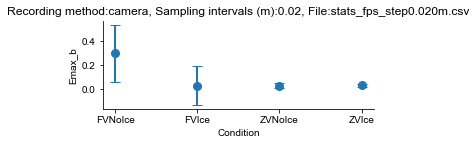

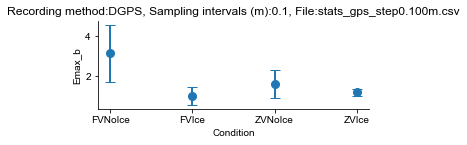

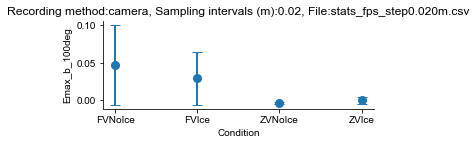

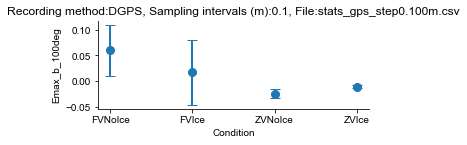

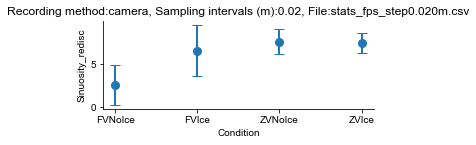

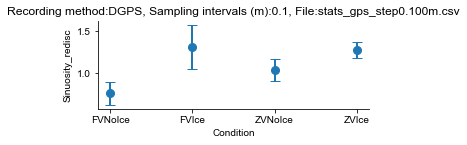

In [25]:
measures = ['Emax_a', 'Emax_b', 'TrajNestNearest', 'Emax_a_unrediscretised', 'Emax_b_unrediscretised', 'EDiffusionDistance', 'ESqDiffusionDistance', 'TrajExpDrift', 'TrajExpDriftDist', 'mean_speed', 'min_C', 'min_deltaS', 'sd_speed', 'sinuosity', 'sinuosity_redisc', 'sinuosity_smooth_redisc', 'straightness_DL_ratio', 'straightness_r', 'Emax_b_100deg']

measures_labels = {
    'Emax_a': 'Emax_a', 
    'Emax_b': 'Emax_b', 
    'Emax_b_100deg': 'Emax_b_100deg', 
    'TrajNestNearest': 'Nearest distance (m)', 
    'Emax_a_unrediscretised': 'Emax_a_unrediscretised', 
    'Emax_b_unrediscretised': 'Emax_b_unrediscretised', 
    'EDiffusionDistance': 'Diffusion distance (m)', 
    'ESqDiffusionDistance': 'Squared diffusion distance', 
    'TrajExpDrift': 'Expected drift', 
    'TrajExpDriftDist': 'Expected drift distance', 
    'mean_speed': 'mean_speed', 
    'min_C': 'min_C', 
    'min_deltaS': 'min_deltaS', 
    'sd_speed': 'sd_speed', 
    'sinuosity': 'Sinuosity', 
    'sinuosity_redisc': 'Sinuosity_redisc', 
    'sinuosity_smooth_redisc': 'Sinuosity_smooth_redisc', 
    'straightness_DL_ratio': 'Straightness_DL_ratio', 
    'straightness_r': 'Straightness_r'
}

# Which types of plots to use can be one of the two or both
plot_type = ['errorplot', 'show_outliers'][0]

path = '../Results/Stats/'

files = {
    # Ant data
    "stats_fps_step0.020m.csv": {"sampling_interval_distance": 0.02, "recording_method": "camera"}, 
    "stats_gps_step0.100m.csv": {"sampling_interval_distance": 0.10, "recording_method": "DGPS"} 
}

def plotMeansOfMeasure(files, stat_significance=False):
    dic_of_df = {}
    for filename in files.keys():
        try:
            df = pd.read_csv(path + filename)
        except:
            print('File {} not available.'.format(path + filename))
            continue
        
        if 'condition' in df and 'noiseSyn' not in df and 'noiseRot' not in df:
            df_pivot = pd.pivot_table(df, index=['condition'])
        if 'condition' in df and 'noiseSyn' in df and 'noiseRot' in df:
            df_pivot = pd.pivot_table(df, index=['condition', 'noiseSyn', 'noiseRot'], aggfunc=np.median)
        print()
        print('Recording method:', files[filename]["recording_method"], ', Sampling intervals (m):', files[filename]["sampling_interval_distance"], ', File:', filename)
        
        display(HTML(df_pivot.to_html()))

        conditions = df.condition.unique().tolist()
        # Do not show this condition
        try:
            conditions.remove('treeFV') # Do not show this condition
        except:
            pass 
        
        try:
            data_list = []
            for i, condition in enumerate(conditions):
                data_list.append(df.loc[df['condition'] == condition][measure])

            fig, ax = plt.subplots(1, 1, figsize=(column_full/2, column_full/2/3))

            if 'errorplot' in plot_type:
                m = []
                sd = []
                min_val = []
                outliers = []
                for idx_i,d in enumerate(data_list):
                    d_without_outliers, d_outliers = reject_outliers(d)
                    m.append(np.median(d_without_outliers))
                    min_val.append(np.min(d_without_outliers))
                    sd.append(np.std(d_without_outliers))
                        
                    outliers.append(d_outliers)
                ax.errorbar(x=np.arange(len(conditions))+1, y=m, yerr=sd, fmt='o', linewidth=2, markersize=8, capsize=5, zorder=1)
                if 'show_outliers' in plot_type and len(d_outliers):
                    ax.scatter([idx_i+1]*len(d_outliers), d_outliers, marker='x', color='red', zorder=2)
                ax.set_xticks(np.arange(len(conditions))+1)
                ax.set_xticklabels(conditions)
                
                # Print out values
                print(measure)
                print('-' * 80)
                print(filename)
                print('{:<10s}'.format(' ')      + str(' {:^20} ' * len(conditions)).format(*conditions))
                print('{:<10s}'.format('Median') + str(' {:^20} ' * len(conditions)).format(*m))
                print('{:<10s}'.format('SD')     + str(' {:^20} ' * len(conditions)).format(*sd))
            
            # If too many conditions try to fit them
            if len(conditions) > 6:
                for label in ax.get_xticklabels():
                    label.set_rotation(45)
                    label.set_ha('center')
            ax.set_xlabel('Condition');
            ax.set_ylabel(measures_labels[measure]);
            ax.set_title('Recording method:' + files[filename]["recording_method"] + ', Sampling intervals (m):' + str(files[filename]["sampling_interval_distance"]) + ', File:' + filename)

            if save_figures:
                if 'fps' in filename:
                    fig.savefig(images_path + 'ants_platformRelease_' + filename.replace('.csv', '') + '_' + measure + save_figures_as_filetype, bbox_inches='tight', transparent=True)
                elif 'gps' in filename:
                    fig.savefig(images_path + 'ants_fullRelease_' + filename.replace('.csv', '') + '_' + measure + save_figures_as_filetype, bbox_inches='tight', transparent=True)
                elif 'simulated'in filename and 'platformReleases' in filename:
                    fig.savefig(images_path + 'simulated_fullRelease_' + filename.replace('.csv', '') + '_' + measure + save_figures_as_filetype, bbox_inches='tight', transparent=True)
            
            if filename == "stats_gps_step0.100m.csv" and stat_significance:
                print()
                print('Statistical significance of two sample means of path lengths:')
                #st = stat_tests(data=data_list, print_data=True)
                data_list_dict = {}
                for i, condition in enumerate(conditions):
                    data_list_dict[condition] = data_list[i]
                st = stat_tests(data=data_list_dict, print_data=True)
        except:
            pass

for m_i in [1, 18, 14]:
    measure = measures[m_i]
    plotMeansOfMeasure(files, stat_significance=True)


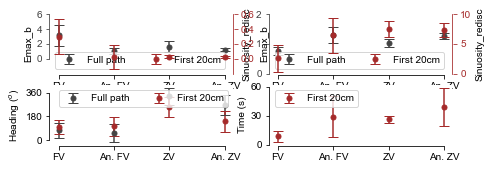

In [26]:
# Plots the ant errorbar plots all together for the paper. 

# Copied here from above for plotting altogether the ants statistics
real_ants_data = {
    'GPS': {
        'Emax_a': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [31.5302582218356, 10.3176102312622, 16.2750364321444, 12.0249773396948],
            'sd'      : [14.325383352300426, 4.487531108686829, 7.144758119095181, 1.8637133480714994]
        }, 
        'Emax_b': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [3.15302582218356, 1.03176102312622, 1.6275036432144399, 1.20249773396948],
            'sd'      : [1.4325383352300423, 0.44875311086868297, 0.7144758119095183, 0.18637133480715007]
        }, 
        'TrajNestNearest': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [7.127161413461475, 10.22697574128825,  10.57343933722575,   9.92759283939856],
            'sd'      : [1.528755439698783,  1.1267538367441179, 0.3391111283899937, 0.13449016007264003]
        }, 
        'sinuosity_redisc': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.755121149514665, 1.31327905768908, 1.03937750982939, 1.27431383037291],
            'sd'      : [0.13730884099125706, 0.26715541675332033, 0.13383796822542393, 0.09533947255978004]
        }, 
        'straightness_r': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.973524952011658, 0.953394099346797, 0.949879743369715, 0.9250088788923895],
            'sd'      : [0.013542570956998536, 0.024457530862177862, 0.011255014492325839, 0.014381310574671513]
        },
        'heading': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'mean'    : [1.282,             0.949,             5.785,             4.597], 
            'sd'      : [0.980,             1.219,             1.089,             1.314], 
            'r'       : [0.520,             0.257,             0.408,             0.137]
        }
    }, 
    'camera': {
        'Emax_a': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [14.7628732864851, 1.34233020145891, 1.26865230983681, 1.36289114719143],
            'sd'      : [11.791451481990247, 7.986602478805116, 1.079383225450193, 0.6203651207951459]
        }, 
        'Emax_b': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.295257465729703, 0.0268466040291783, 0.0253730461967362, 0.0272578229438287],
            'sd'      : [0.23582902963980523, 0.15973204957610238, 0.021587664509003856, 0.012407302415902953]
        }, 
        'TrajNestNearest': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [10.8266502737215,    10.8294962206449,    10.9540688207057,     10.9265272442551],
            'sd'      : [0.033684654044847245, 0.06106366808014325, 0.020711684455312983, 0.03312569267991858]
        }, 
        'sinuosity_redisc': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [2.55965745922281, 6.49178802540813, 7.51932345741891, 7.32666375151968],
            'sd'      : [2.270146269395501, 2.9560749398484205, 1.4180696377206659, 1.166951565282718]
        }, 
        'straightness_r': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.943027856885317, 0.6552366909224889, 0.594538075964726, 0.576832747214129],
            'sd'      : [0.1561190119835832, 0.21302056450214446, 0.12294651192982278, 0.12446565449696617]
        },
        'heading': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'mean'    : [1.689,             1.836,             4.340,             2.483], 
            'sd'      : [0.947,             1.249,             1.316,             1.371],
            'r'       : [0.551,             0.219,             0.134,             0.061]
        },
        'time': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'mean'    : [8.436923076923078, 28.765333333333334, 26.253333333333334, 38.973333333333336], 
            'sd'      : [5.902770385577612, 21.39778862925378,  3.915144385020246,  19.641108816855414]            
        }
    }    
}


condition_label = {
    'FVNoIce' : 'FV', 
    'FVIce'   : 'An. FV', 
    'ZVNoIce' : 'ZV', 
    'ZVIce'   : 'An. ZV'
}

def conditionsToLabels(lst):
    if not isinstance(lst, list):
        lst = [lst]
    return [condition_label[item] for item in lst]
    
recording_methods_names = ['Full path', 'First 20cm']

markersize=5
capsize=5

colour1 = 'tab:blue'
colour1 = '#444444'
colour2 = 'tab:orange'
colour2 = 'tab:red'
colour2 = 'brown'
#colour2 = 'darkred'

fig, axs = plt.subplots(2, 2, figsize=(column_double, column_double/3))
#fig, axs = plt.subplots(2, 2, figsize=(12, 7))

ax = axs[0,0]
twin1 = ax.twinx()
measure    = 'Emax_b'
recording_method_i = 0
conditions = real_ants_data['GPS'][measure]['condition']
median     = real_ants_data['GPS'][measure]['median']
std        = real_ants_data['GPS'][measure]['sd']
p1 = ax.errorbar(x=np.arange(len(conditions))+1, y=median, yerr=std, fmt='o', color=colour1, markersize=markersize, capsize=capsize, label=recording_methods_names[recording_method_i])
recording_method_i = 1
conditions = real_ants_data['camera'][measure]['condition']
median     = np.array(real_ants_data['camera'][measure]['median'])
std        = np.array(real_ants_data['camera'][measure]['sd'])
p2 = twin1.errorbar(x=np.arange(len(conditions))+1, y=median, yerr=std, fmt='o', color=colour2, markersize=markersize, capsize=capsize, label=recording_methods_names[recording_method_i])
ax.set_ylabel(measures_labels[measure]);
twin1.set_ylabel(measures_labels[measure]);
ax.set_xticks(np.arange(len(conditions))+1);
ax.set_xticklabels(conditionsToLabels(conditions));
#ax.legend(ncol=2)
lns = [p1, p2]
ax.legend(handles=lns, loc='best', ncol=len(lns))
#ax.yaxis.label.set_color(colour1)
#twin1.yaxis.label.set_color(colour2)
tkw = dict(size=4, width=1.5)
tkw = dict()
ax.tick_params(axis='y', colors=colour1, **tkw)
twin1.tick_params(axis='y', colors=colour2, **tkw)
ax.tick_params(axis='x', **tkw)
ax.spines['left'].set_color(colour1)
ax.spines['right'].set_color(colour2)
ax.set_yticks([0, 2, 4, 6]);
ax.set_ylim([-2, 6])
twin1.set_yticks([0.0, 0.2, 0.4, 0.6]);
twin1.set_ylim([-0.2, 0.6])
adjust_spines(ax, ['left', 'bottom'], x_values=np.array([1, 4]), y_values=np.array([0, 6]), margin=1)
adjust_spines(twin1, ['right'], x_values=np.array([1, 4]), y_values=np.array([0.0, 0.6]), margin=1)
ax.spines['right'].set_visible(True)

ax = axs[0,1]
twin1 = ax.twinx()
measure    = 'sinuosity_redisc'
recording_method_i = 0
conditions = real_ants_data['GPS'][measure]['condition']
median     = np.array(real_ants_data['GPS'][measure]['median'])
std        = np.array(real_ants_data['GPS'][measure]['sd'])
p1 = ax.errorbar(x=np.arange(len(conditions))+1, y=median, yerr=std, fmt='o', color=colour1, markersize=markersize, capsize=capsize, label=recording_methods_names[recording_method_i])
recording_method_i = 1
conditions = real_ants_data['camera'][measure]['condition']
median     = real_ants_data['camera'][measure]['median']
std        = real_ants_data['camera'][measure]['sd']
p2 = twin1.errorbar(x=np.arange(len(conditions))+1, y=median, yerr=std, fmt='o', color=colour2, markersize=markersize, capsize=capsize, label=recording_methods_names[recording_method_i])
ax.set_ylabel(measures_labels[measure]);
twin1.set_ylabel(measures_labels[measure]);
ax.set_xticks(np.arange(len(conditions))+1);
ax.set_xticklabels(conditionsToLabels(conditions));
#ax.legend(ncol=2)
lns = [p1, p2]
ax.legend(handles=lns, loc='best', ncol=len(lns))
#ax.yaxis.label.set_color(colour1)
#twin1.yaxis.label.set_color(colour2)
tkw = dict(size=4, width=1.5)
tkw = dict()
ax.tick_params(axis='y', colors=colour1, **tkw)
twin1.tick_params(axis='y', colors=colour2, **tkw)
ax.tick_params(axis='x', **tkw)
ax.spines['left'].set_color(colour1)
ax.spines['right'].set_color(colour2)
ax.set_yticks([0, 1, 2]);
ax.set_ylim([0, 2])
twin1.set_yticks([0, 5, 10]);
twin1.set_ylim([0, 10])
adjust_spines(ax, ['left', 'bottom'], x_values=np.array([1, 4]), y_values=np.array([0, 2]), margin=1)
adjust_spines(twin1, ['right'], x_values=np.array([1, 4]), y_values=np.array([0, 10]), margin=1)
ax.spines['right'].set_visible(True)

ax = axs[1,0]
measure    = 'heading'
recording_method_i = 0
conditions = real_ants_data['GPS'][measure]['condition']
median     = real_ants_data['GPS'][measure]['mean']
std        = real_ants_data['GPS'][measure]['sd']
ax.errorbar(x=np.arange(len(conditions))+1, y=np.degrees(median), yerr=np.degrees(std), fmt='o', color=colour1, markersize=markersize, capsize=capsize, label=recording_methods_names[recording_method_i])
recording_method_i = 1
conditions = real_ants_data['camera'][measure]['condition']
median     = real_ants_data['camera'][measure]['mean']
std        = real_ants_data['camera'][measure]['sd']
ax.errorbar(x=np.arange(len(conditions))+1, y=np.degrees(median), yerr=np.degrees(std), fmt='o', color=colour2, markersize=markersize, capsize=capsize, label=recording_methods_names[recording_method_i])
ax.set_ylabel('Heading ($^o$)');
ax.set_xticks(np.arange(len(conditions))+1);
ax.set_xticklabels(conditionsToLabels(conditions));
ax.legend(ncol=2)
ax.set_yticks([0, 180, 360]);
adjust_spines(ax, ['left', 'bottom'], x_values=np.array([1, 4]), y_values=np.array([0, 360]), margin=1)

ax = axs[1,1]
measure    = 'time'
conditions = real_ants_data['camera'][measure]['condition']
median     = real_ants_data['camera'][measure]['mean']
std        = real_ants_data['camera'][measure]['sd']
ax.errorbar(x=np.arange(len(conditions))+1, y=median, yerr=std, fmt='o', color=colour2, markersize=markersize, capsize=capsize, label=recording_methods_names[recording_method_i])
ax.set_ylabel('Time (s)');
ax.set_xticks(np.arange(len(conditions))+1);
ax.set_xticklabels(conditionsToLabels(conditions));
ax.legend()
ax.set_yticks([0, 30, 60]);
adjust_spines(ax, ['left', 'bottom'], x_values=np.array([1, 4]), y_values=np.array([0, 60]), margin=1)

if save_figures:
    fig.savefig(images_path + 'ants_allReleases_' + 'Emax_Sinuosity_Theta_Time_within_20cm' + save_figures_as_filetype, bbox_inches='tight', transparent=True)


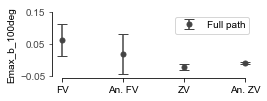

In [27]:
# Plots the Emaxb for the DGPS ant paths with assumed direction to 100deg. 

# Copied here from above for plotting the ants statistics
real_ants_data = {
    'GPS': {
        # Emax_b_100deg values from above
        'Emax_b_100deg': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.0600632623424949, 0.0174183380698823, -0.0240606366865208, -0.011026657077781],
            'sd'      : [0.04987695857567853, 0.06342166645023738, 0.009383912485339539, 0.0028780313523546]
        } 
    }
}


condition_label = {
    'FVNoIce' : 'FV', 
    'FVIce'   : 'An. FV', 
    'ZVNoIce' : 'ZV', 
    'ZVIce'   : 'An. ZV'
}

def conditionsToLabels(lst):
    if not isinstance(lst, list):
        lst = [lst]
    return [condition_label[item] for item in lst]
    
recording_methods_names = ['Full path', 'First 20cm']

# Plot styling
markersize=5
capsize=5

colour1 = '#444444'

fig = plt.figure(figsize=(column_double/2, column_double/3/2))
ax = plt.gca()

measure    = 'Emax_b_100deg'
recording_method_i = 0
conditions = real_ants_data['GPS'][measure]['condition']
median     = real_ants_data['GPS'][measure]['median']
std        = real_ants_data['GPS'][measure]['sd']
p1 = ax.errorbar(x=np.arange(len(conditions))+1, y=median, yerr=std, fmt='o', color=colour1, markersize=markersize, capsize=capsize, label=recording_methods_names[recording_method_i])
ax.set_ylabel(measures_labels[measure]);
ax.set_xticks(np.arange(len(conditions))+1);
ax.set_xticklabels(conditionsToLabels(conditions));

lns = [p1]
ax.legend(handles=lns, loc='best', ncol=len(lns))

tkw = dict(size=4, width=1.5)
tkw = dict()
ax.tick_params(axis='y', colors=colour1, **tkw)
ax.tick_params(axis='x', **tkw)

ax.set_yticks([-0.05, 0.05, 0.15]);

adjust_spines(ax, ['left', 'bottom'], x_values=np.array([1, 4]), y_values=np.array([-0.05, 0.15]), margin=1)

if save_figures:
    fig.savefig(images_path + 'ants_allReleases_' + 'Emax_b_100deg_fullPaths' + save_figures_as_filetype, bbox_inches='tight', transparent=True)


## Plot the path characteristics of the simulated agents superimposed with the ant data

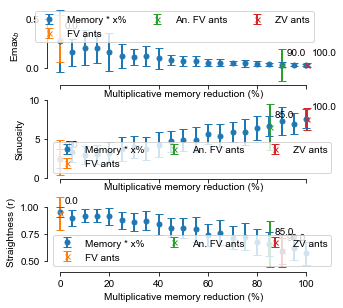

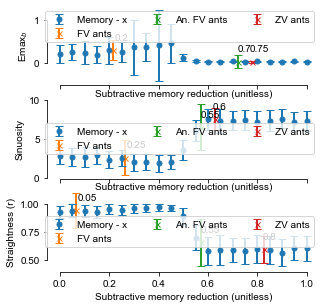

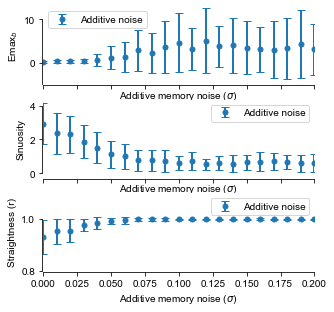

In [28]:
# Plot styling
markersize=5
capsize=4

print_numeric_stats = False
no_titles = True

show_FVNoIce = True
show_FVIce = True
show_ZVNoIce = True
show_simulated_FV = False
show_simulated_ZV = False

path = '../Results/Stats/'

measures = ['Emax_a', 'Emax_b', 'TrajNestNearest', 'Emax_a_unrediscretised', 'Emax_b_unrediscretised', 'EDiffusionDistance', 'ESqDiffusionDistance', 'TrajExpDrift', 'TrajExpDriftDist', 'mean_speed', 'min_C', 'min_deltaS', 'sd_speed', 'sinuosity', 'sinuosity_redisc', 'sinuosity_smooth_redisc', 'straightness_DL_ratio', 'straightness_r']
show_measures = [1, 14, 17]

noiseSyn = 0.1
noiseRot = 7

measures_labels = {
    'Emax_a': 'Emax$_a$', 
    'Emax_b': 'Emax$_b$', 
    'TrajNestNearest': 'Nearest distance (m)', 
    'Emax_a_unrediscretised': 'Emax_a_unrediscretised', 
    'Emax_b_unrediscretised': 'Emax_b_unrediscretised', 
    'EDiffusionDistance': 'Diffusion distance (m)', 
    'ESqDiffusionDistance': 'Squared diffusion distance', 
    'TrajExpDrift': 'Expected drift', 
    'TrajExpDriftDist': 'Expected drift distance', 
    'mean_speed': 'mean_speed', 
    'min_C': 'min_C', 
    'min_deltaS': 'min_deltaS', 
    'sd_speed': 'sd_speed', 
    'sinuosity': 'Sinuosity', 
    'sinuosity_redisc': 'Sinuosity', 
    'sinuosity_smooth_redisc': 'Sinuosity_smooth_redisc', 
    'straightness_DL_ratio': 'Straightness_DL_ratio', 
    'straightness_r': 'Straightness (r)'
}

# Copied here from above the ants statistics
real_ants_data = {
    'GPS': {
        'Emax_a': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [31.5302582218356, 10.3176102312622, 16.2750364321444, 12.0249773396948],
            'sd'      : [14.325383352300426, 4.487531108686829, 7.144758119095181, 1.8637133480714994]
        }, 
        'Emax_b': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [3.15302582218356, 1.03176102312622, 1.6275036432144399, 1.20249773396948],
            'sd'      : [1.4325383352300423, 0.44875311086868297, 0.7144758119095183, 0.18637133480715007]
        }, 
        'TrajNestNearest': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [7.127161413461475, 10.22697574128825,  10.57343933722575,   9.92759283939856],
            'sd'      : [1.528755439698783,  1.1267538367441179, 0.3391111283899937, 0.13449016007264003]
        }, 
        'sinuosity_redisc': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.755121149514665, 1.31327905768908, 1.03937750982939, 1.27431383037291],
            'sd'      : [0.13730884099125706, 0.26715541675332033, 0.13383796822542393, 0.09533947255978004]
        }, 
        'straightness_r': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.973524952011658, 0.953394099346797, 0.949879743369715, 0.9250088788923895],
            'sd'      : [0.013542570956998536, 0.024457530862177862, 0.011255014492325839, 0.014381310574671513]
        }
    }, 
    'camera': {
        'Emax_a': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [14.7628732864851, 1.34233020145891, 1.26865230983681, 1.36289114719143],
            'sd'      : [11.791451481990247, 7.986602478805116, 1.079383225450193, 0.6203651207951459]
        }, 
        'Emax_b': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.295257465729703, 0.0268466040291783, 0.0253730461967362, 0.0272578229438287],
            'sd'      : [0.23582902963980523, 0.15973204957610238, 0.021587664509003856, 0.012407302415902953]
        }, 
        'TrajNestNearest': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [10.8266502737215,    10.8294962206449,    10.9540688207057,     10.9265272442551],
            'sd'      : [0.033684654044847245, 0.06106366808014325, 0.020711684455312983, 0.03312569267991858]
        }, 
        'sinuosity_redisc': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [2.55965745922281, 6.49178802540813, 7.51932345741891, 7.32666375151968],
            'sd'      : [2.270146269395501, 2.9560749398484205, 1.4180696377206659, 1.166951565282718]
        }, 
        'straightness_r': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.943027856885317, 0.6552366909224889, 0.594538075964726, 0.576832747214129],
            'sd'      : [0.1561190119835832, 0.21302056450214446, 0.12294651192982278, 0.12446565449696617]
        }
    }    
}


files = {
    # Simulated data
    "stats_simulated_with_Pontin_Holonomic_platformReleases_step0.020m.csv": {"sampling_interval_distance": 0.020, "recording_method": "simulated"}, 
}

# What memory manipulations to plot
memManipulationTypesList = [
    'Multiply', 
    'Subtract', 
    'Noise'
]

    
memManipulationTypes = {
    'FVNoIce' : 'FV ants', 
    'FVIce'   : 'An. FV ants', 
    'ZVNoIce' : 'ZV ants', 
    'FV'      : 'FV simulated', 
    'ZV'      : 'ZV simulated', 
    'Multiply': 'Memory * x%', 
    'Subtract': 'Memory - x', 
    'Noise'   : 'Additive noise', 
    'Equal'   : 'CPU4 = x (ZV)',         
}


def getSelectedData(df_pivot, condition, memManipulationType, measure, noiseSyn = 0.1, noiseRot = 20):
    """ 
        Select and return the memory degradation level, the median, and 
        SD data as arrays for the specified index conditions. 
    """
    
    temp1 = df_pivot.query('condition == "'+condition+'" & noiseSyn == '+str(noiseSyn)+' & noiseRot == '+str(noiseRot)+' & MemManipType == "' + memManipulationType + '"')

    # The memory manipulation levels
    MemDegradation = temp1.index.get_level_values('MemDegradation')
    
    temp = temp1.loc[:, [('median_without_outliers', measure), ('std_without_outliers', measure)]].values
    
    # The median and SD arrays
    med = temp[:,0]
    std = temp[:,1]

    return MemDegradation, med, std

def median_without_outliers(x):
    without_outliers, outliers = reject_outliers(x)
    if len(without_outliers) > 0:
        x = without_outliers
    return np.median(x)

def std_without_outliers(x):
    without_outliers, outliers = reject_outliers(x)
    if len(without_outliers) > 0:
        x = without_outliers
    return np.std(x)

for filename in files.keys():
    try:
        df = pd.read_csv(path + filename)
    except:
        print('File {} not available.'.format(path + filename))
        continue

    # Calculate the median and SD
    df_pivot = pd.pivot_table(df, index=['condition', 'noiseSyn', 'noiseRot', 'MemManipType', 'MemDegradation'], aggfunc=[median_without_outliers, std_without_outliers])

    for i, memManipulationType in enumerate(memManipulationTypesList):
        
        fig, axs = plt.subplots(len(show_measures), 1, figsize=(column_full/2, column_full/2/3*len(show_measures)), sharex=True)

        for midx, m1 in enumerate(show_measures):
            measure = measures[m1]

            if isinstance(axs, (list,np.ndarray)):
                ax = axs[midx]
            else:
                ax = axs
            
            # For shifting the errorbars horizontally so they do not overlap
            bar_trans = []
            trans_step = 0.007
            for k in range(0, 5):
                bar_trans.append(Affine2D().translate(trans_step*(k+1), 0.0) + ax.transData)

            # Select the entries with manipulated memory ("FVIce") and MemManipType==memManipulationType and get the median and SD for all MemDegradation values
            MemDegradation, m, sd = getSelectedData(df_pivot, "FVIce", memManipulationType, measure, noiseSyn = noiseSyn, noiseRot = noiseRot)
            if memManipulationType == 'Multiply':
                MemDegradation = (1 - MemDegradation) * 100
            
            ax.errorbar(x=MemDegradation, y=m, yerr=sd, fmt='o', linewidth=2, markersize=markersize, capsize=capsize, zorder=1, label=memManipulationTypes[memManipulationType])

            #if filename == "stats_simulated_with_Pontin_Holonomic_platformReleases_step0.020m.csv" and memManipulationType == 'GPS':
            if '_platformReleases' in filename:
                recordingType = 'camera'
            else:
                recordingType = 'GPS'

            con = real_ants_data[recordingType][measure]['condition']
            med = real_ants_data[recordingType][measure]['median']
            std = real_ants_data[recordingType][measure]['sd']
            
            if print_numeric_stats:
                print(recordingType, measure)
                print(con)
                print(med)
                print(std)
            
            if print_numeric_stats:
                print('MemDegradation', MemDegradation)
            
            k = 1
            j = 0 # FVNoIce
            if print_numeric_stats:
                print('m', m)
                print('med[j]', med[j])
                print('np.abs(m - med[j])', np.abs(m - med[j]))

            if show_FVNoIce and memManipulationType != 'Noise':
                best_match_memdeg_FVNoIce = MemDegradation[np.argmin(np.abs(m - med[j]))]
                ax.errorbar(x=[best_match_memdeg_FVNoIce], y=[med[j]], yerr=[std[j]], fmt='x', linewidth=2, markersize=markersize, capsize=capsize, zorder=1, label=memManipulationTypes[con[j]], transform=bar_trans[k])
                ax.annotate(f'{best_match_memdeg_FVNoIce}', xy=(best_match_memdeg_FVNoIce, med[j]), xytext=(5, 10), textcoords='offset points')

            if show_FVIce and memManipulationType != 'Noise':
                k += 1
                j = 1 # FVIce
                best_match_memdeg_FVIce = MemDegradation[np.argmin(np.abs(m - med[j]))]
                ax.errorbar(x=[best_match_memdeg_FVIce], y=[med[j]], yerr=[std[j]], fmt='x', linewidth=2, markersize=markersize, capsize=capsize, zorder=1, label=memManipulationTypes[con[j]], transform=bar_trans[k])
                ax.annotate(f'{best_match_memdeg_FVIce}', xy=(best_match_memdeg_FVIce, med[j]), xytext=(5, 10), textcoords='offset points')

            if show_ZVNoIce and memManipulationType != 'Noise':
                k += 1
                j = 2 # ZVNoIce
                best_match_memdeg_ZVNoIce = MemDegradation[np.argmin(np.abs(m - med[j]))]
                ax.errorbar(x=[best_match_memdeg_ZVNoIce], y=[med[j]], yerr=[std[j]], fmt='x', linewidth=2, markersize=markersize, capsize=capsize, zorder=1, label=memManipulationTypes[con[j]], transform=bar_trans[k])
                ax.annotate(f'{best_match_memdeg_ZVNoIce}', xy=(best_match_memdeg_ZVNoIce, med[j]), xytext=(5, 10), textcoords='offset points')

            if show_simulated_FV:
                k += 1 # FV simulated
                controlMemConditionType = 'FV'
                # Select the entries with the MemManipType==memManipulationType and get the median and SD for all MemDegradation values
                MemDegradation2, med, std = getSelectedData(df_pivot, controlMemConditionType, "None", measure, noiseSyn = noiseSyn, noiseRot = noiseRot)
                best_match_memdeg_FV2 = MemDegradation[np.argmin(np.abs(m - med))]
                ax.errorbar(x=[best_match_memdeg_FV2], y=med, yerr=std, fmt='+', linewidth=2, markersize=markersize, capsize=capsize, zorder=1, label=memManipulationTypes[controlMemConditionType], transform=bar_trans[k])

            if show_simulated_ZV:
                k += 1 # ZV simulated
                controlMemConditionType = 'ZV'
                # Select the entries with the MemManipType==memManipulationType and get the median and SD for all MemDegradation values
                MemDegradation3, med, std = getSelectedData(df_pivot, controlMemConditionType, "None", measure, noiseSyn = noiseSyn, noiseRot = noiseRot)
                best_match_memdeg_ZV2 = MemDegradation[np.argmin(np.abs(m - med))]
                ax.errorbar(x=[best_match_memdeg_ZV2], y=med, yerr=std, fmt='+', linewidth=2, markersize=markersize, capsize=capsize, zorder=1, label=memManipulationTypes[controlMemConditionType], transform=bar_trans[k])

            ax.legend(ncol=k, frameon=True) # , mode='expand'

            ax.set_ylabel(measures_labels[measure]);
            if not no_titles: 
                ax.set_title('Recording method:' + files[filename]["recording_method"] + ', Sampling intervals (m):' + str(files[filename]["sampling_interval_distance"]) + ', File:' + filename)
            
            if memManipulationType == 'Noise':
                ax.set_xlim([0, 0.2]);

            if memManipulationType == 'Multiply':
                ax.set_xlabel('Multiplicative memory reduction (%)');
                x_values=np.array([0, 100])
                if measure == 'Emax_a':
                    y_values=np.array([0,  30])
                    ax.set_ylim([None,  30])
                elif measure == 'Emax_b':
                    y_values=np.array([0,   0.5])
                elif measure == 'sinuosity_redisc':
                    y_values=np.array([0,  10])
                    ax.set_ylim([0, 10])
                elif measure == 'straightness_r':
                    y_values=np.array([0.5, 1.0])
            elif memManipulationType == 'Subtract':
                ax.set_xlabel('Subtractive memory reduction (unitless)');
                x_values=np.array([0, 1])
                if measure == 'Emax_a':
                    y_values=np.array([-25,  50])
                elif measure == 'Emax_b':
                    y_values=np.array([0,   1.0])
                    ax.set_ylim([-0.5, None])
                elif measure == 'sinuosity_redisc':
                    y_values=np.array([0,  10])
                    ax.set_ylim([0, 10])
                elif measure == 'straightness_r':
                    y_values=np.array([0.5, 1.0])
                    ax.set_ylim([0.4,  1.1])
            elif memManipulationType == 'Noise':
                ax.set_xlabel('Additive memory noise ($\sigma$)');
                x_values=np.array([0, 0.2])
                if measure == 'Emax_a':
                    y_values=np.array([-250,  500])
                elif measure == 'Emax_b':
                    y_values=np.array([-5,   10])
                    ax.set_ylim([-5, 13])
                elif measure == 'sinuosity_redisc':
                    y_values=np.array([0,  4])
                    #ax.set_ylim([0, 10])
                elif measure == 'straightness_r':
                    y_values=np.array([0.8, 1.0])
                    ax.set_ylim([0.8,  1.1])

            # Beautify the axes
            adjust_spines(ax, ['left', 'bottom'], x_values=x_values, y_values=y_values, margin=1)

            if save_figures:
                if 'platformReleases' in filename:
                    fig.savefig(images_path + 'memory_manipulation_effect_' + memManipulationType + '_' + '_ants_platformRelease_overlapping_' + filename.replace('.csv', '') + save_figures_as_filetype, bbox_inches='tight', transparent=True)
                else:
                    fig.savefig(images_path + 'memory_manipulation_effect_' + memManipulationType + '_' + '_ants_fullRelease_overlapping_' + filename.replace('.csv', '') + save_figures_as_filetype, bbox_inches='tight', transparent=True)


best_match_memdeg_FVIce = 90.0
best_match_memdeg_FVIce = 85.0
best_match_memdeg_FVIce = 85.0
best_match_memdeg_FVIce = 85.0
best_match_memdeg_FVIce = 85.0
best_match_memdeg_FVIce = 0.7
best_match_memdeg_FVIce = 0.55
best_match_memdeg_FVIce = 0.55
best_match_memdeg_FVIce = 0.55
best_match_memdeg_FVIce = 0.55
best_match_memdeg_FVIce = 0.0
best_match_memdeg_FVIce = 0.0
best_match_memdeg_FVIce = 0.0
best_match_memdeg_FVIce = 0.0
best_match_memdeg_FVIce = 0.0


/Users/john/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:324: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


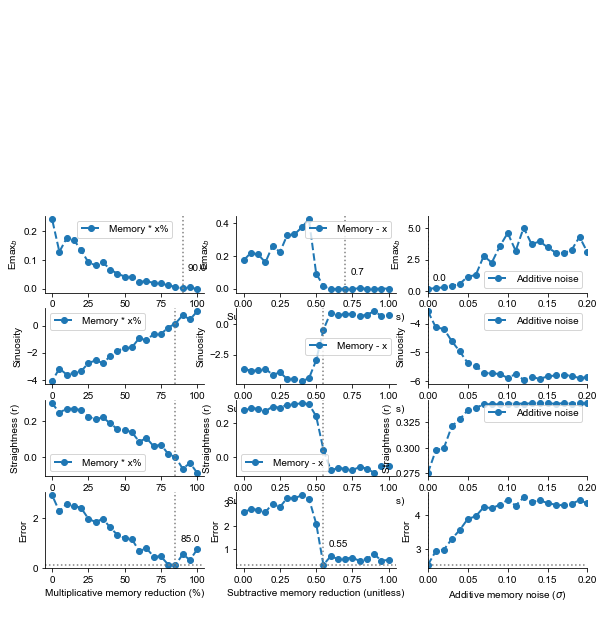

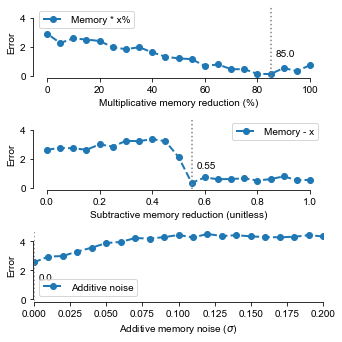

In [29]:
# Plot the ant and model match error

# Plot styling
markersize=5
capsize=4

print_numeric_stats = False
no_titles = True

show_FVNoIce = True
show_FVIce = True
show_ZVNoIce = True
show_simulated_FV = False
show_simulated_ZV = False

path = '../Results/Stats/'

measures = ['Emax_a', 'Emax_b', 'TrajNestNearest', 'Emax_a_unrediscretised', 'Emax_b_unrediscretised', 'EDiffusionDistance', 'ESqDiffusionDistance', 'TrajExpDrift', 'TrajExpDriftDist', 'mean_speed', 'min_C', 'min_deltaS', 'sd_speed', 'sinuosity', 'sinuosity_redisc', 'sinuosity_smooth_redisc', 'straightness_DL_ratio', 'straightness_r']
show_measures = [1, 14, 17]

noiseSyn = 0.1
noiseRot = 7

measures_labels = {
    'Emax_a': 'Emax$_a$', 
    'Emax_b': 'Emax$_b$', 
    'TrajNestNearest': 'Nearest distance (m)', 
    'Emax_a_unrediscretised': 'Emax_a_unrediscretised', 
    'Emax_b_unrediscretised': 'Emax_b_unrediscretised', 
    'EDiffusionDistance': 'Diffusion distance (m)', 
    'ESqDiffusionDistance': 'Squared diffusion distance', 
    'TrajExpDrift': 'Expected drift', 
    'TrajExpDriftDist': 'Expected drift distance', 
    'mean_speed': 'mean_speed', 
    'min_C': 'min_C', 
    'min_deltaS': 'min_deltaS', 
    'sd_speed': 'sd_speed', 
    'sinuosity': 'Sinuosity', 
    'sinuosity_redisc': 'Sinuosity', 
    'sinuosity_smooth_redisc': 'Sinuosity_smooth_redisc', 
    'straightness_DL_ratio': 'Straightness_DL_ratio', 
    'straightness_r': 'Straightness (r)'
}

# Copied here from above the ants statistics
real_ants_data = {
    'GPS': {
        'Emax_a': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [31.5302582218356, 10.3176102312622, 16.2750364321444, 12.0249773396948],
            'sd'      : [14.325383352300426, 4.487531108686829, 7.144758119095181, 1.8637133480714994]
        }, 
        'Emax_b': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [3.15302582218356, 1.03176102312622, 1.6275036432144399, 1.20249773396948],
            'sd'      : [1.4325383352300423, 0.44875311086868297, 0.7144758119095183, 0.18637133480715007]
        }, 
        'TrajNestNearest': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [7.127161413461475, 10.22697574128825,  10.57343933722575,   9.92759283939856],
            'sd'      : [1.528755439698783,  1.1267538367441179, 0.3391111283899937, 0.13449016007264003]
        }, 
        'sinuosity_redisc': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.755121149514665, 1.31327905768908, 1.03937750982939, 1.27431383037291],
            'sd'      : [0.13730884099125706, 0.26715541675332033, 0.13383796822542393, 0.09533947255978004]
        }, 
        'straightness_r': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.973524952011658, 0.953394099346797, 0.949879743369715, 0.9250088788923895],
            'sd'      : [0.013542570956998536, 0.024457530862177862, 0.011255014492325839, 0.014381310574671513]
        }
    }, 
    'camera': {
        'Emax_a': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [14.7628732864851, 1.34233020145891, 1.26865230983681, 1.36289114719143],
            'sd'      : [11.791451481990247, 7.986602478805116, 1.079383225450193, 0.6203651207951459]
        }, 
        'Emax_b': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.295257465729703, 0.0268466040291783, 0.0253730461967362, 0.0272578229438287],
            'sd'      : [0.23582902963980523, 0.15973204957610238, 0.021587664509003856, 0.012407302415902953]
        }, 
        'TrajNestNearest': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [10.8266502737215,    10.8294962206449,    10.9540688207057,     10.9265272442551],
            'sd'      : [0.033684654044847245, 0.06106366808014325, 0.020711684455312983, 0.03312569267991858]
        }, 
        'sinuosity_redisc': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [2.55965745922281, 6.49178802540813, 7.51932345741891, 7.32666375151968],
            'sd'      : [2.270146269395501, 2.9560749398484205, 1.4180696377206659, 1.166951565282718]
        }, 
        'straightness_r': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.943027856885317, 0.6552366909224889, 0.594538075964726, 0.576832747214129],
            'sd'      : [0.1561190119835832, 0.21302056450214446, 0.12294651192982278, 0.12446565449696617]
        }
    }    
}

files = {
    # Simulated data
    "stats_simulated_with_Pontin_Holonomic_platformReleases_step0.020m.csv": {"sampling_interval_distance": 0.020, "recording_method": "simulated"}, 
}

# What to plot
memManipulationTypesList = [
    'Multiply', 
    'Subtract', 
    'Noise'
]
    
memManipulationTypes = {
    'FVNoIce' : 'FV ants', 
    'FVIce'   : 'An. FV ants', 
    'ZVNoIce' : 'ZV ants', 
    'FV'      : 'FV simulated', 
    'ZV'      : 'ZV simulated', 
    'Multiply': 'Memory * x%', 
    'Subtract': 'Memory - x', 
    'Noise'   : 'Additive noise', 
    'Equal'   : 'CPU4 = x (ZV)',         
}


def getSelectedData(df_pivot, condition, memManipulationType, measure, noiseSyn = 0.1, noiseRot = 20):
    """ 
        Select and return the memory degradation level, the median, and 
        SD data as arrays for the specified index conditions. 
    """
    temp1 = df_pivot.query('condition == "'+condition+'" & noiseSyn == '+str(noiseSyn)+' & noiseRot == '+str(noiseRot)+' & MemManipType == "' + memManipulationType + '"')
    
    # The memory manipulation levels
    MemDegradation = temp1.index.get_level_values('MemDegradation')
    temp = temp1.loc[:, [('median_without_outliers', measure), ('std_without_outliers', measure)]].values
    
    # The median and SD arrays
    med = temp[:,0]
    std = temp[:,1]

    return MemDegradation, med, std

def median_without_outliers(x):
    without_outliers, outliers = reject_outliers(x)
    if len(without_outliers) > 0:
        x = without_outliers
    return np.median(x)

def std_without_outliers(x):
    without_outliers, outliers = reject_outliers(x)
    if len(without_outliers) > 0:
        x = without_outliers
    return np.std(x)

def setAxesRanges(ax, memManipulationType, measure):
    if memManipulationType == 'Noise':
        ax.set_xlim([0, 0.2])

    if memManipulationType == 'Multiply':
        ax.set_xlabel('Multiplicative memory reduction (%)')
        x_values=np.array([0, 100])
        if measure == 'Emax_a':
            y_values=np.array([0,  30])
        elif measure == 'Emax_b':
            y_values=np.array([0,   0.5])
        elif measure == 'sinuosity_redisc':
            y_values=np.array([0,  10])
        elif measure == 'straightness_r':
            y_values=np.array([0.5, 1.0])
    elif memManipulationType == 'Subtract':
        ax.set_xlabel('Subtractive memory reduction (unitless)')
        x_values=np.array([0, 1])
        if measure == 'Emax_a':
            y_values=np.array([-25,  50])
        elif measure == 'Emax_b':
            y_values=np.array([0,   1.0])
        elif measure == 'sinuosity_redisc':
            y_values=np.array([0,  10])
        elif measure == 'straightness_r':
            y_values=np.array([0.5, 1.0])
    elif memManipulationType == 'Noise':
        ax.set_xlabel('Additive memory noise ($\sigma$)')
        x_values=np.array([0, 0.2])
        if measure == 'Emax_a':
            y_values=np.array([-250,  500])
        elif measure == 'Emax_b':
            y_values=np.array([-5,   10])
        elif measure == 'sinuosity_redisc':
            y_values=np.array([0,  4])
        elif measure == 'straightness_r':
            y_values=np.array([0.8, 1.0])
    return (x_values, y_values)

for filename in files.keys():
    try:
        df = pd.read_csv(path + filename)
    except:
        print('File {} not available.'.format(path + filename))
        continue

    # Calculate the median and SD
    df_pivot = pd.pivot_table(df, index=['condition', 'noiseSyn', 'noiseRot', 'MemManipType', 'MemDegradation'], aggfunc=[median_without_outliers, std_without_outliers])

    fig, axs = plt.subplots(len(show_measures)+1, len(memManipulationTypesList), figsize=(column_full, column_full/2/3*(len(show_measures)+1)))
    fig2, axs2 = plt.subplots(len(show_measures), 1, figsize=(column_full/2, column_full/2/3*len(show_measures)), sharey=True)

    for i, memManipulationType in enumerate(memManipulationTypesList):
        # Initialise the match score to 1's because we multiply matching scores
        match_score = np.array([])
        
        for midx, m1 in enumerate(show_measures):
            measure = measures[m1]

            if isinstance(axs, (list,np.ndarray)):
                ax = axs[midx,i]
            else:
                ax = axs

            # Select the entries with manipulated memory ("FVIce") and MemManipType==memManipulationType and get the median and SD for all MemDegradation values
            MemDegradation, m, sd = getSelectedData(df_pivot, "FVIce", memManipulationType, measure, noiseSyn = noiseSyn, noiseRot = noiseRot)
            if memManipulationType == 'Multiply':
                MemDegradation = (1 - MemDegradation) * 100

            #if filename == "stats_simulated_with_Pontin_Holonomic_platformReleases_step0.020m.csv" and memManipulationType == 'GPS':
            if '_platformReleases' in filename:
                recordingType = 'camera'
            else:
                recordingType = 'GPS'
            
            con = real_ants_data[recordingType][measure]['condition']
            med = real_ants_data[recordingType][measure]['median']
            std = real_ants_data[recordingType][measure]['sd']
            
            if print_numeric_stats:
                print(recordingType, measure)
                print(con)
                print(med)
                print(std)
            
            if print_numeric_stats:
                print('MemDegradation', MemDegradation)
            
            k = 1
            j = 0 # FVNoIce
            if print_numeric_stats:
                print('m', m)
                print('med[j]', med[j])
                print('np.abs(m - med[j])', np.abs(m - med[j]))

            j = 1 # FVIce
            model_error = m - med[j]
            ax.plot(MemDegradation, model_error, '--o', linewidth=2, label=memManipulationTypes[memManipulationType])
            
            # Factor error in the total score
            if match_score.size == 0:
                match_score = model_error
            else:
                match_score = match_score + model_error * model_error
            
            if show_FVIce:
                k += 1
                j = 1 # FVIce
                best_match_memdeg_FVIce = MemDegradation[np.argmin(np.abs(m - med[j]))]
                ax.annotate(f'{best_match_memdeg_FVIce}', xy=(best_match_memdeg_FVIce, med[j]), xytext=(5, 10), textcoords='offset points')
                ax.axvline(x=best_match_memdeg_FVIce, color='grey', linestyle='dotted')
                print('best_match_memdeg_FVIce =', best_match_memdeg_FVIce)
            
            ax.legend(ncol=k, frameon=True) # , mode='expand'

            ax.set_ylabel(measures_labels[measure]);
            if not no_titles: 
                ax.set_title('Recording method:' + files[filename]["recording_method"] + ', Sampling intervals (m):' + str(files[filename]["sampling_interval_distance"]) + ', File:' + filename)
            
            setAxesRanges(ax, memManipulationType, measure)
        
        if isinstance(axs, (list,np.ndarray)):
            ax = axs[midx+1,i]
        else:
            ax = axs
        
        ax.plot(MemDegradation, np.sqrt(match_score/midx), '--o', linewidth=2, label=memManipulationTypes[memManipulationType])
        ax.set_ylabel('RMSE')
        ax.set_ylabel('Error')
        
        if show_FVIce:
            k += 1
            j = 1 # FVIce
            best_match_memdeg_FVIce = MemDegradation[np.argmin(np.abs(match_score))]
            best_match_memdeg_FVIce = MemDegradation[np.argmin(np.sqrt(match_score/midx))]
            ax.annotate(f'{best_match_memdeg_FVIce}', xy=(best_match_memdeg_FVIce, med[j]), xytext=(5, 10), textcoords='offset points')
            ax.axvline(x=best_match_memdeg_FVIce, color='grey', linestyle='dotted')
            print('best_match_memdeg_FVIce =', best_match_memdeg_FVIce)
            setAxesRanges(ax, memManipulationType, measure)
        
            ax.axhline(y=np.min(np.sqrt(match_score/midx)), color='grey', linestyle='dotted')

        axs2[i].plot(MemDegradation, np.sqrt(match_score/midx), '--o', linewidth=2, label=memManipulationTypes[memManipulationType])
        axs2[i].set_ylabel('RMSE')
        axs2[i].set_ylabel('Error')
        if show_FVIce:
            k += 1
            j = 1 # FVIce
            best_match_memdeg_FVIce = MemDegradation[np.argmin(np.abs(match_score))]
            best_match_memdeg_FVIce = MemDegradation[np.argmin(np.sqrt(match_score/midx))]
            axs2[i].annotate(f'{best_match_memdeg_FVIce}', xy=(best_match_memdeg_FVIce, med[j]), xytext=(5, 10), textcoords='offset points')
            axs2[i].axvline(x=best_match_memdeg_FVIce, color='grey', linestyle='dotted')
            print('best_match_memdeg_FVIce =', best_match_memdeg_FVIce)
        x_values, y_values = setAxesRanges(axs2[i], memManipulationType, measure)
        axs2[i].legend()
        
        # Beautify the axes
        adjust_spines(axs2[i], ['left', 'bottom'], x_values=x_values, y_values=np.array([0,4]), margin=1)
        
    if save_figures:
        if 'platformReleases' in filename:
            fig.savefig(images_path + 'memory_manipulation_effect_error_' + memManipulationType + '_' + '_ants_platformRelease_' + filename.replace('.csv', '') + save_figures_as_filetype, bbox_inches='tight', transparent=True)
            fig2.savefig(images_path + 'memory_manipulation_effect_total_error_only_' + memManipulationType + '_' + '_ants_platformRelease_' + filename.replace('.csv', '') + save_figures_as_filetype, bbox_inches='tight', transparent=True)
        else:
            fig.savefig(images_path + 'memory_manipulation_effect_error_' + memManipulationType + '_' + '_ants_fullRelease_' + filename.replace('.csv', '') + save_figures_as_filetype, bbox_inches='tight', transparent=True)
            fig2.savefig(images_path + 'memory_manipulation_effect_total_error_only_' + memManipulationType + '_' + '_ants_fullRelease_' + filename.replace('.csv', '') + save_figures_as_filetype, bbox_inches='tight', transparent=True)
    else:
        fig.tight_layout()
        fig2.tight_layout()
        

FV platformRelease Diff Emax_a Min = 1.286 (slope, noise) = (5, 9)
ZV platformRelease Diff Emax_a Min = 0.471 (slope, noise) = (12, 10)
FV full trajectory Diff Emax_a Min = 0.193 (slope, noise) = (6, 10)
ZV full trajectory Diff Emax_a Min = 0.000 (slope, noise) = (5, 7)

FV platformRelease Diff Emax_b Min = 0.026 (slope, noise) = (5, 9)
ZV platformRelease Diff Emax_b Min = 0.009 (slope, noise) = (12, 10)
FV full trajectory Diff Emax_b Min = 0.019 (slope, noise) = (6, 10)
ZV full trajectory Diff Emax_b Min = 0.000 (slope, noise) = (5, 7)

FV platformRelease Diff Sinuosity_redisc Min = 0.396 (slope, noise) = (9, 1)
ZV platformRelease Diff Sinuosity_redisc Min = 0.462 (slope, noise) = (9, 1)
FV full trajectory Diff Sinuosity_redisc Min = 0.719 (slope, noise) = (18, 1)
ZV full trajectory Diff Sinuosity_redisc Min = 0.000 (slope, noise) = (5, 7)

FV platformRelease Diff Straightness_r Min = 0.586 (slope, noise) = (5, 9)
ZV platformRelease Diff Straightness_r Min = 0.349 (slope, noise) = (11

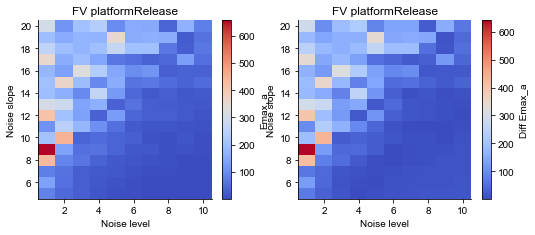

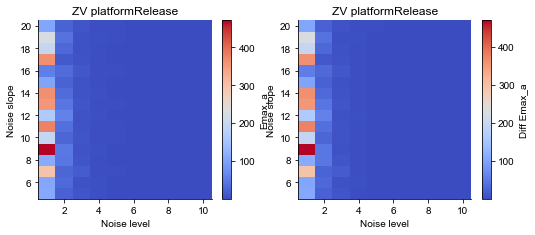

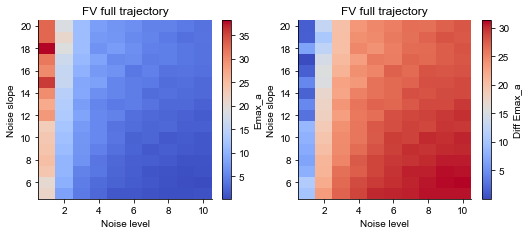

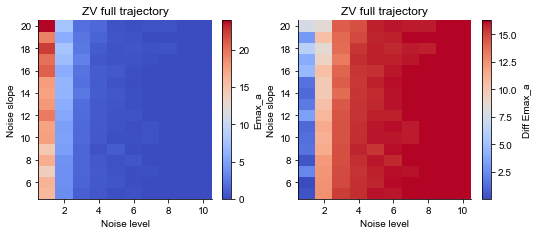

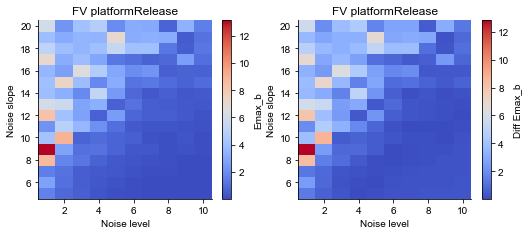

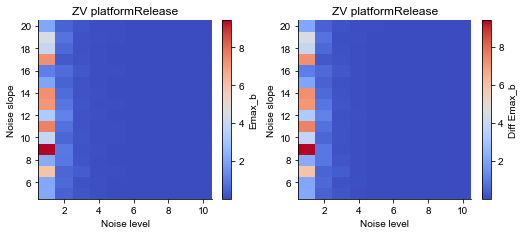

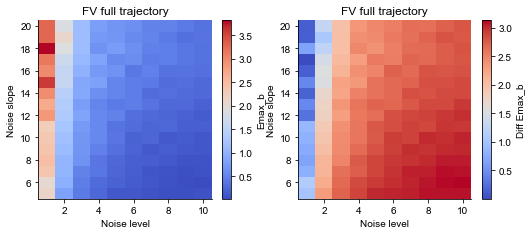

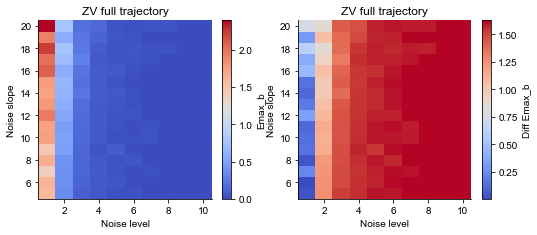

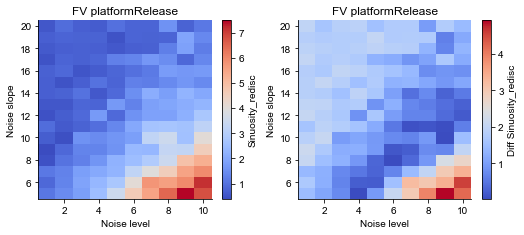

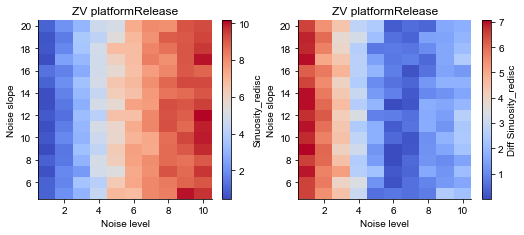

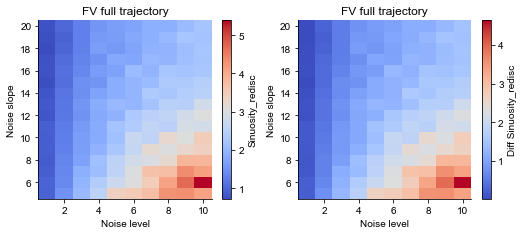

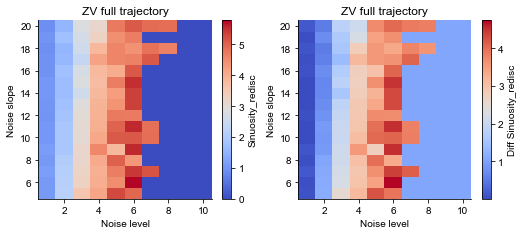

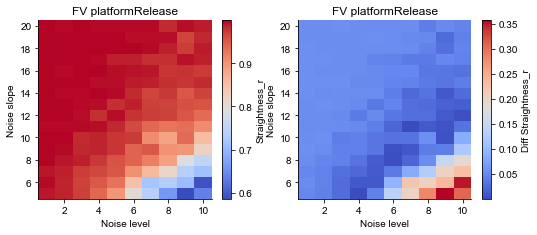

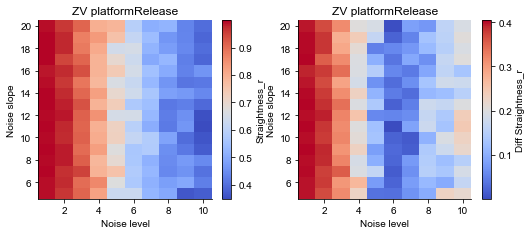

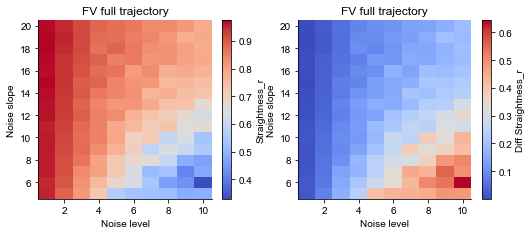

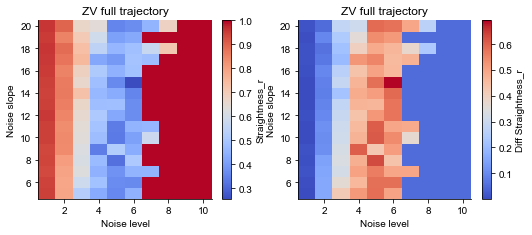

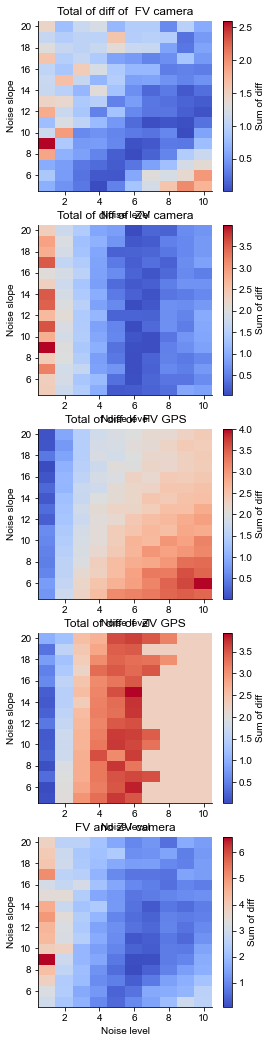

In [31]:
# This was used for exploring the noise levels and noise slope values and find the levels that produce similar statistics with the real FV and ZV ants
print_numeric_stats = False
save_to_pdf_file = False
show_all_or_high_res_focused = 'focused' # 'all' or 'focused' to show all data sparsely sampled or focused with high resolution

mm_per_in = 25.4 
fig_width  = 83 / mm_per_in + 1 # mm / mm_per_in
fig_height = 58 / mm_per_in + 1 # mm / mm_per_in

from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages

path = '../Results/Stats/Rediscetized/Simulated_scaling0.03/'
params_subdirs = ['Stats_Noise_X_slope_Y_ymax1.0_ymin0.0_600steps']
params_subdirs = [params_subdirs[0]] # Show only this one

measures = ['Emax_a', 'Emax_b', 'TrajNestNearest', 'Emax_a_unrediscretised', 'Emax_b_unrediscretised', 'EDiffusionDistance', 'ESqDiffusionDistance', 'TrajExpDrift', 'TrajExpDriftDist', 'mean_speed', 'min_C', 'min_deltaS', 'sd_speed', 'sinuosity', 'sinuosity_redisc', 'sinuosity_smooth_redisc', 'straightness_DL_ratio', 'straightness_r']
show_measures = [0, 1, 14, 17]

measures_labels = {
    'Emax_a': 'Emax_a', 
    'Emax_b': 'Emax_b', 
    'TrajNestNearest': 'Nearest distance (m)', 
    'Emax_a_unrediscretised': 'Emax_a_unrediscretised', 
    'Emax_b_unrediscretised': 'Emax_b_unrediscretised', 
    'EDiffusionDistance': 'Diffusion distance (m)', 
    'ESqDiffusionDistance': 'Squared diffusion distance', 
    'TrajExpDrift': 'Expected drift', 
    'TrajExpDriftDist': 'Expected drift distance', 
    'mean_speed': 'mean_speed', 
    'min_C': 'min_C', 
    'min_deltaS': 'min_deltaS', 
    'sd_speed': 'sd_speed', 
    'sinuosity': 'Sinuosity', 
    'sinuosity_redisc': 'Sinuosity_redisc', 
    'sinuosity_smooth_redisc': 'Sinuosity_smooth_redisc', 
    'straightness_DL_ratio': 'Straightness_DL_ratio', 
    'straightness_r': 'Straightness_r'
}

# Copied here from above the real ants statistics
real_ants_data = {
    'GPS': {
        'Emax_a': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [31.5302582218356, 10.3176102312622, 16.2750364321444, 12.0249773396948],
            'sd'      : [14.325383352300426, 4.487531108686829, 7.144758119095181, 1.8637133480714994]
        }, 
        'Emax_b': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [3.15302582218356, 1.03176102312622, 1.6275036432144399, 1.20249773396948],
            'sd'      : [1.4325383352300423, 0.44875311086868297, 0.7144758119095183, 0.18637133480715007]
        }, 
        'TrajNestNearest': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [7.127161413461475, 10.22697574128825,  10.57343933722575,   9.92759283939856],
            'sd'      : [1.528755439698783,  1.1267538367441179, 0.3391111283899937, 0.13449016007264003]
        }, 
        'sinuosity_redisc': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.755121149514665, 1.31327905768908, 1.03937750982939, 1.27431383037291],
            'sd'      : [0.13730884099125706, 0.26715541675332033, 0.13383796822542393, 0.09533947255978004]
        }, 
        'straightness_r': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.973524952011658, 0.953394099346797, 0.949879743369715, 0.9250088788923895],
            'sd'      : [0.013542570956998536, 0.024457530862177862, 0.011255014492325839, 0.014381310574671513]
        }
    }, 
    'camera': {
        'Emax_a': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [14.7628732864851, 1.34233020145891, 1.26865230983681, 1.36289114719143],
            'sd'      : [11.791451481990247, 7.986602478805116, 1.079383225450193, 0.6203651207951459]
        }, 
        'Emax_b': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.295257465729703, 0.0268466040291783, 0.0253730461967362, 0.0272578229438287],
            'sd'      : [0.23582902963980523, 0.15973204957610238, 0.021587664509003856, 0.012407302415902953]
        }, 
        'TrajNestNearest': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [10.8266502737215,    10.8294962206449,    10.9540688207057,     10.9265272442551],
            'sd'      : [0.033684654044847245, 0.06106366808014325, 0.020711684455312983, 0.03312569267991858]
        }, 
        'sinuosity_redisc': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [2.55965745922281, 6.49178802540813, 7.51932345741891, 7.32666375151968],
            'sd'      : [2.270146269395501, 2.9560749398484205, 1.4180696377206659, 1.166951565282718]
        }, 
        'straightness_r': {
            'condition':['FVNoIce',         'FVIce',           'ZVNoIce',         'ZVIce'], 
            'median'  : [0.943027856885317, 0.6552366909224889, 0.594538075964726, 0.576832747214129],
            'sd'      : [0.1561190119835832, 0.21302056450214446, 0.12294651192982278, 0.12446565449696617]
        }
    }    
}

files = {
    # Simulated data
    "stats_simulated_with_Pontin_Holonomic_FV_noiseRot_combined_noiseSlope_combined_platformReleases_step0.020m.csv": {"sampling_interval_distance": 0.020, "recording_method": "simulated"}, 
    "stats_simulated_with_Pontin_Holonomic_ZV_noiseRot_combined_noiseSlope_combined_platformReleases_step0.020m.csv": {"sampling_interval_distance": 0.020, "recording_method": "simulated"}, 
    "stats_simulated_with_Pontin_Holonomic_FV_noiseRot_combined_noiseSlope_combined_step0.100m.csv": {"sampling_interval_distance": 0.100, "recording_method": "simulated"}, 
    "stats_simulated_with_Pontin_Holonomic_ZV_noiseRot_combined_noiseSlope_combined_step0.100m.csv": {"sampling_interval_distance": 0.100, "recording_method": "simulated"} 
}


def getSelectedData(df_pivot, measure, condition, noiseSyn = 0.1, noiseRot = 10):
    """ 
        Select and return the memory degradation level, the median, and 
        SD data as arrays for the specified index conditions. """
    temp1 = df_pivot.query('condition == "'+condition+'" & noiseSyn == '+str(noiseSyn)+' & noiseRot == '+str(noiseRot))
    
    # The memory manipulation levels
    noiseSlope = temp1.index.get_level_values('noiseSlope')
    temp = temp1.loc[:, [('median', measure), ('std', measure)]].values
    
    # The median and SD arrays
    med = temp[:,0]
    std = temp[:,1]

    return noiseSlope, med, std

def argmin_coords(x):
    x = np.array(x)
    row, col = np.unravel_index(x.argmin(), x.shape)
    min_val = x.min()
    return (row, col, min_val)

dic_of_df = {}
if save_to_pdf_file:
    pdf = PdfPages('2D_multipage_pdf.pdf')
for subdir in params_subdirs: 
    total_data_res = {}
    for m1 in show_measures:
        if save_to_pdf_file:
            fig, axs = plt.subplots(len(files.keys()), 2, figsize=(8.25-2, 11.75-2))

        measure = measures[m1]
        for idx, filename in enumerate(files.keys()):
            try:
                df = pd.read_csv(path + subdir + '/' + filename)
            except:
                print('File {} not available.'.format(path + subdir + '/' + filename))
                continue

            if 'condition' in df and 'noiseSyn' not in df and 'noiseRot' not in df:
                df_pivot = pd.pivot_table(df, index=['condition'])
            if 'condition' in df and 'noiseSyn' in df and 'noiseRot' in df and 'noiseSlope' in df:
                df_pivot = pd.pivot_table(df, index=['condition', 'noiseSyn', 'noiseRot', 'noiseSlope'], aggfunc=[np.median, np.std])
            if print_numeric_stats:
                print()
                print('Recording method:', files[filename]["recording_method"], ', Sampling intervals (m):', files[filename]["sampling_interval_distance"], ', File:', filename)

            if not save_to_pdf_file:
                fig, ax = plt.subplots(1, 2, figsize=(fig_width*2, fig_height))
            else:
                ax = axs[idx]


            conditions = df.condition.unique().tolist()
            
            conditions = df_pivot.index.get_level_values('condition').unique().tolist()
            
            # Get the motor noise levels
            noise_conds = df_pivot.index.get_level_values('noiseRot').unique().tolist()
            noise_slopes = df_pivot.index.get_level_values('noiseSlope').unique().tolist()
            
            if show_all_or_high_res_focused == 'all':
                noise_slope_levels = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50]
                sampled_rows = noise_slope_levels
                noise_levels  = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
                sampled_cols = noise_levels
            elif show_all_or_high_res_focused == 'focused':                
                noise_slope_levels = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
                sampled_rows = noise_slope_levels
                noise_levels  = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                sampled_cols = noise_levels
            
            if '_platformReleases' in filename:
                recordingType = 'camera'
            else:
                recordingType = 'GPS'

            data = {}
            data_res = {}
            if recordingType not in total_data_res:
                total_data_res[recordingType] = {}
            for condition in conditions:
                data[condition] = {}
                data_res[condition] = {}
                if condition not in total_data_res[recordingType]:
                    total_data_res[recordingType][condition] = {}
                data[condition]['med'] = np.ones((max(max(noise_slopes), max(sampled_rows))+1, max(max(noise_conds), max(sampled_cols))+1)) * 100
                data[condition]['std'] = np.ones((max(max(noise_slopes), max(sampled_rows))+1, max(max(noise_conds), max(sampled_cols))+1)) * 100
                data[condition]['msk'] = np.ones((max(max(noise_slopes), max(sampled_rows))+1, max(max(noise_conds), max(sampled_cols))+1)) > 2 # Create a mask of values with all set to False
                for noiseRot in noise_conds:
                    noiseSlopes, med, std = getSelectedData(df_pivot, measure, condition, noiseSyn = 0.1, noiseRot = noiseRot)
                    
                    for l, noiseSlope in enumerate(noiseSlopes):
                        data[condition]['med'][noiseSlope, noiseRot] = med[l]
                        data[condition]['std'][noiseSlope, noiseRot] = std[l]
                        data[condition]['msk'][noiseSlope, noiseRot] = True # Set to True
                
                # Set all non filled cells to the max or min value
                all_set_values_list = data[condition]['med'][data[condition]['msk']]
                all_set_values_list_min = np.min(all_set_values_list)
                all_set_values_list_max = np.max(all_set_values_list)
                if measure in ['Emax_a', 'Emax_b', 'sinuosity', 'sinuosity_redisc', 'sinuosity_smooth_redisc']:
                    data[condition]['med'][~data[condition]['msk']] = all_set_values_list_min
                    data[condition]['med'][~data[condition]['msk']] = 0
                else:
                    data[condition]['med'][~data[condition]['msk']] = all_set_values_list_max
                    data[condition]['med'][~data[condition]['msk']] = 1

                # Keep only sampled rows and columns 
                data_res[condition]['med'] = data[condition]['med'][sampled_rows,:][:,sampled_cols]
                data_res[condition]['std'] = data[condition]['std'][sampled_rows,:][:,sampled_cols]

                # Find difference from real ant statistics
                real_con = real_ants_data[recordingType][measure]['condition']
                real_med = real_ants_data[recordingType][measure]['median']
                real_std = real_ants_data[recordingType][measure]['sd']

                # Get the difference
                if '_FV_' in filename:
                    data_res_diff = data_res[condition]['med'] - real_med[0]
                elif '_ZV_' in filename:
                    data_res_diff = data_res[condition]['med'] - real_med[2]
                data_res_diff = np.abs(data_res_diff)
                
                # Keep a sum of error for each condition and recordng type
                if 'diffsum' not in total_data_res[recordingType][condition]:
                    total_data_res[recordingType][condition]['diffsum'] = (data_res_diff / np.max(data_res_diff))
                else:
                    total_data_res[recordingType][condition]['diffsum'] = total_data_res[recordingType][condition]['diffsum'] + (data_res_diff / np.max(data_res_diff))
                
                # Surface plot
                X, Y = np.meshgrid(sampled_cols, sampled_rows)
                # plot_surface -> pcolor
                surf1 = ax[0].pcolor(X, Y, data_res[condition]['med'], cmap=cm.coolwarm, linewidth=0, antialiased=False, shading='auto')
                surf2 = ax[1].pcolor(X, Y, data_res_diff, cmap=cm.coolwarm, linewidth=0, antialiased=False,shading='auto')                

                ax[0].set_xlabel('Noise level');
                ax[0].set_ylabel('Noise slope');
                
                cb = fig.colorbar(surf1, ax=ax[0])
                cb.set_label(measures_labels[measure])
                ax[1].set_xlabel('Noise level');
                ax[1].set_ylabel('Noise slope');
                
                cb = fig.colorbar(surf2, ax=ax[1])
                cb.set_label('Diff ' + measures_labels[measure])

                tilte_str = ''
                if '_FV_' in filename: 
                    tilte_str += 'FV '
                else: 
                    tilte_str += 'ZV '

                if '_platformRelease' in filename:
                    tilte_str += 'platformRelease'
                else: 
                    tilte_str += 'full trajectory'
                ax[0].set_title(tilte_str)
                ax[1].set_title(tilte_str)
                
                if save_figures:
                    fig.savefig(images_path + 'motor_noise_function_grid_search_' + show_all_or_high_res_focused + '_' + tilte_str.replace(' ', '_') + '_' + measures_labels[measure] + save_figures_as_filetype, bbox_inches='tight', transparent=True)

                # Get the minimum coordinates
                row, col, min_val = argmin_coords(data_res[condition]['med'])
                
                # Print the combination of noise values that give the minimum deviation from real ant stats values
                print(tilte_str, 'Diff ' + measures_labels[measure], 'Min = {:.3f}'.format(min_val), '(slope, noise) =', (sampled_rows[row], sampled_cols[col]))

        print()

        if save_to_pdf_file:
            fig.suptitle(subdir)
            pdf.savefig(fig, bbox_inches='tight', pad_inches=0)
            plt.close(fig)

    # Calculate the total error for each condition
    fig, ax = plt.subplots(len(files.keys())+1, 1, figsize=(fig_width-0.375, (fig_height+1)*len(files.keys())+1))
    for idx, filename in enumerate(files.keys()):
        if '_platformReleases' in filename:
            recordingType = 'camera'
        else:
            recordingType = 'GPS'
        if '_FV_' in filename:
            condition = 'FV'
        elif '_ZV_' in filename:
            condition = 'ZV'
        surf4 = ax[idx].pcolor(X, Y, total_data_res[recordingType][condition]['diffsum'], cmap=cm.coolwarm, linewidth=0, antialiased=False, shading='auto')
        ax[idx].set_xlabel('Noise level');
        ax[idx].set_ylabel('Noise slope');
        
        cb = fig.colorbar(surf4, ax=ax[idx])
        cb.set_label('Sum of diff')
        
        ax[idx].set_title('Total of diff of ' + ' ' + condition + ' ' + recordingType)
        
        # Get the minimum coordinates
        row, col, min_val = argmin_coords(total_data_res[recordingType][condition]['diffsum'])
        
        # Print the combination of noise values that give the minimum deviation from real ant stats values
        print('Total of diff of', condition, recordingType, 'Min = {:.3f}'.format(min_val), '(slope, noise) =', (sampled_rows[row], sampled_cols[col]))
    
    print()
    
    idx += 1
    total_of_total_data_res = total_data_res['camera']['FV']['diffsum'] + total_data_res['camera']['ZV']['diffsum']
    surf5 = ax[idx].pcolor(X, Y, total_of_total_data_res, cmap=cm.coolwarm, linewidth=0, antialiased=False, shading='auto')                
    ax[idx].set_xlabel('Noise level');
    ax[idx].set_ylabel('Noise slope');

    cb = fig.colorbar(surf5, ax=ax[idx])
    cb.set_label('Sum of diff')
    
    ax[idx].set_title('FV and ZV' + ' ' + 'camera')
    
    if save_figures:
        fig.savefig(images_path + 'motor_noise_function_grid_search_' + show_all_or_high_res_focused + '_' + ('Total Sums of diff').replace(' ', '_') + save_figures_as_filetype, bbox_inches='tight', transparent=True)

    # Get the minimum coordinates
    row, col, min_val = argmin_coords(total_of_total_data_res)
    
    # Print the combination of noise values that give the minimum deviation from real ant stats values
    print('Total of diff of FV and ZV with camera ', 'Min = {:.3f}'.format(min_val), '(slope, noise) =', (sampled_rows[row], sampled_cols[col]))

if save_to_pdf_file:
    pdf.close()
